In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass  #this might not be needed anymore
from os import environ, name
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

## Loading the data
Including parsed action logs (dfx) and survey/test results (df_scores)

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
gitpath = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
dfx = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
dfx["student"] = dfx["student"].astype('category')
dfx["Family"]=dfx["Family"].str.capitalize()

max_time = 25*60*1000
max_times = {s:min(dfx[dfx['student']==s]["Time Stamp"])+max_time for s in set(dfx['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

dfx['keep'] = dfx.apply (lambda row: keep_by_time (row),axis=1)
dfx=dfx[dfx['keep']]

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

## Action families
Action types are defined along with converter to shortform names and colors for sequence timeline plots

In [3]:
#Recall that these are all the possible action types (aka action families) from parsed log file:
print set(dfx['Family'])
# (1) Construct (e.g. adding/removing stuff on circuit)
# (2) Interface (e.g. zooming) 
# (3) Pause (inaction for >15secs)
# (4) Test__other (e.g. using grab bag resistor, no battery in circuit, only having a single lightbulb (rare) )
# (5) Test__basic (1 resistor and 1 loop)
# (6) Test__simple (2 resistors with 1 or 2 loops)
# (7) Test__complex ( any other combinations of loop/resistors OR if contains lightbulb and at least 1 resistor (rare) )

converter =  {"Construct" : "C",
"Interface" : "I",
"Pause" : "P",
"Test_basic" : "Tb",
"Test_complex" : "Tc",
"Test_other" : "To",
"Test_simple" : "Ts"
    }

# color dict for plotting action timeline plots
color_pos =  {'Construct':('#31a354',1),
    'Pause':('#969696',2),
    'Test_basic': ('#fb6a4a',3),
    'Test_simple': ('#a50f15',4),
    'Test_complex': ('#4a1486',5),
    'Test_other':('#c51b8a',6),
    'Interface':('#c51b8a',6)
    }

set(['Test_other', 'Pause', 'Test_simple', 'Construct', 'Test_basic', 'Test_complex', 'Interface'])


## Functions 

In [4]:
def get_blocks_withTime_new(df, students, ignore=[], add_spaces=False):
    
    '''
    This function gets action sequences in block form along with time stamps for each block for plotting.
    '''

    def convert(action,ignore):
        return converter[action]
    
    blocks = {student:'' for student in students}

    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
#         print sequence
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        ##use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            ##for matches of action denoted by more than 1 letter (e.g. Tb), need to correct the span
            #print match.group(), match.span(), ind[1]-ind[0], len(set(match.group())),
            ##set() function yields unique elements of a set, which allows picking out those actions with > 1 letter
            ##for e.g. if match.group() gives "CCCCC", then set() of that is "C" while for "TbTbTb" we'd have "T","b"
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            #print ind
            previous_start = ind[1]
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords
 

In [5]:
def plot_barGraph_new(df, ACTIVITY, studentID, pltFamilies, axis_labels, ignore=[]):
    '''
    This function plots timeline action plots
    '''
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coords = get_blocks_withTime_new(df[df.Activity==ACTIVITY],{studentID})
    #create figure and axes
    fig, ax = plt.subplots()

    #need this to convert desired action families back to letter code
    def convert(action,ignore):
        return converter[action]
    
    #split sequences so that each block is an element of a list
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,3})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]
    #grab time coordinates of each blocks from dict 
    time_coord = time_coords[studentID]
    for action in pltFamilies: 
        nn = color_pos[action][1]
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        #print action
        #print (blocks[studentID])
        #print len(splitblocks), len(time_coord)
        if convert(action,[]) in splitblocks:
#             print convert(action,[])
#             print sum([1 for s in splitblocks if s ==convert(action,()) ])
            #out = [(x,y) for x,y in zip(splitblocks,time_coord) if any(convert(action,[]) == z for z in x)]
            out = [(x,y) for x,y in zip(splitblocks,time_coord) if convert(action,[]) == x]
            try:
                _, time_coord_filtered = map(list,zip(*out))  
                ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=color_pos[action][0])
            except:
                print 'failed', action,convert(action,[])
#                 for x,y in zip(splitblocks,time_coord):
#                     print convert(action,[]), x,y, convert(action,[]) == x
                pass
    ax.set_ylim(5, len(axis_labels)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)
    return None

## Student groups

In [6]:
#Show all the test and survey data for all students (for reference)
df_scores

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
0,March,scaff,2,2,0,0,1,1,1,0,0,0.21,-0.42,0.64,0.79,0.75,-1.52,-0.42,0.33,2.67,2.78,2.67,4.0,3.50,attitude,scaffolded_attitude,1075123,1920143974
1,March,scaff,2,3,0,0,1,0,1,1,0,0.50,0.33,0.55,0.71,0.38,0.19,0.33,-0.12,2.44,3.11,3.33,4.5,3.25,attitude,scaffolded_attitude,3591123,-714775387
2,March,not,2,3,0,0,1,1,1,2,1,0.42,0.08,0.44,0.58,-0.16,-0.30,0.08,-0.72,2.22,2.78,2.44,3.5,3.00,attitude,notscaffolded_attitude,3932129,1194576952
3,March,scaff,2,3,1,1,1,1,1,2,0,0.54,-1.42,0.35,0.42,-0.88,0.43,-1.42,-1.18,3.00,3.22,3.11,4.5,3.00,attitude,scaffolded_attitude,4762120,-450686147
4,July,not,1,2,1,0,1,0,1,0,0,0.63,-1.75,0.54,0.46,-0.70,0.92,-1.75,-0.18,2.67,3.22,2.78,5.0,3.00,knowledge,notscaffolded_knowledge,4936123,-901793583
5,March,scaff,2,3,0,1,1,1,1,0,0,0.75,0.58,0.91,1.00,1.65,1.64,0.58,1.79,2.78,2.78,2.89,4.0,3.00,knowledge,scaffolded_knowledge,8580120,1682116183
6,March,not,2,3,1,1,1,1,1,0,1,0.38,1.09,0.77,0.92,1.29,-0.54,1.09,1.03,3.44,3.11,3.22,4.5,2.25,attitude,notscaffolded_attitude,8775127,1873578806
7,July,scaff,1,3,0,0,1,1,1,0,0,0.21,-0.72,0.27,0.21,-1.79,-1.52,-0.72,-1.62,2.67,2.33,2.33,2.0,3.25,attitude,scaffolded_attitude,8889108,1140619053
8,July,scaff,1,2,1,0,1,0,1,2,1,0.38,-1.34,0.30,0.29,-1.43,-0.54,-1.34,-1.49,2.33,2.78,3.00,2.5,2.25,knowledge,scaffolded_knowledge,9331415,-1573761483
9,March,not,3,3,0,0,0,1,1,1,1,0.46,-0.17,0.40,0.38,-1.07,-0.06,-0.17,-0.91,2.89,2.11,2.67,4.0,2.75,attitude,notscaffolded_attitude,10009106,986526943


There are a total of 74 novices of which LL=36 and LH=38
There are a total of 22 incoming experts of which HH=19 and HL=3


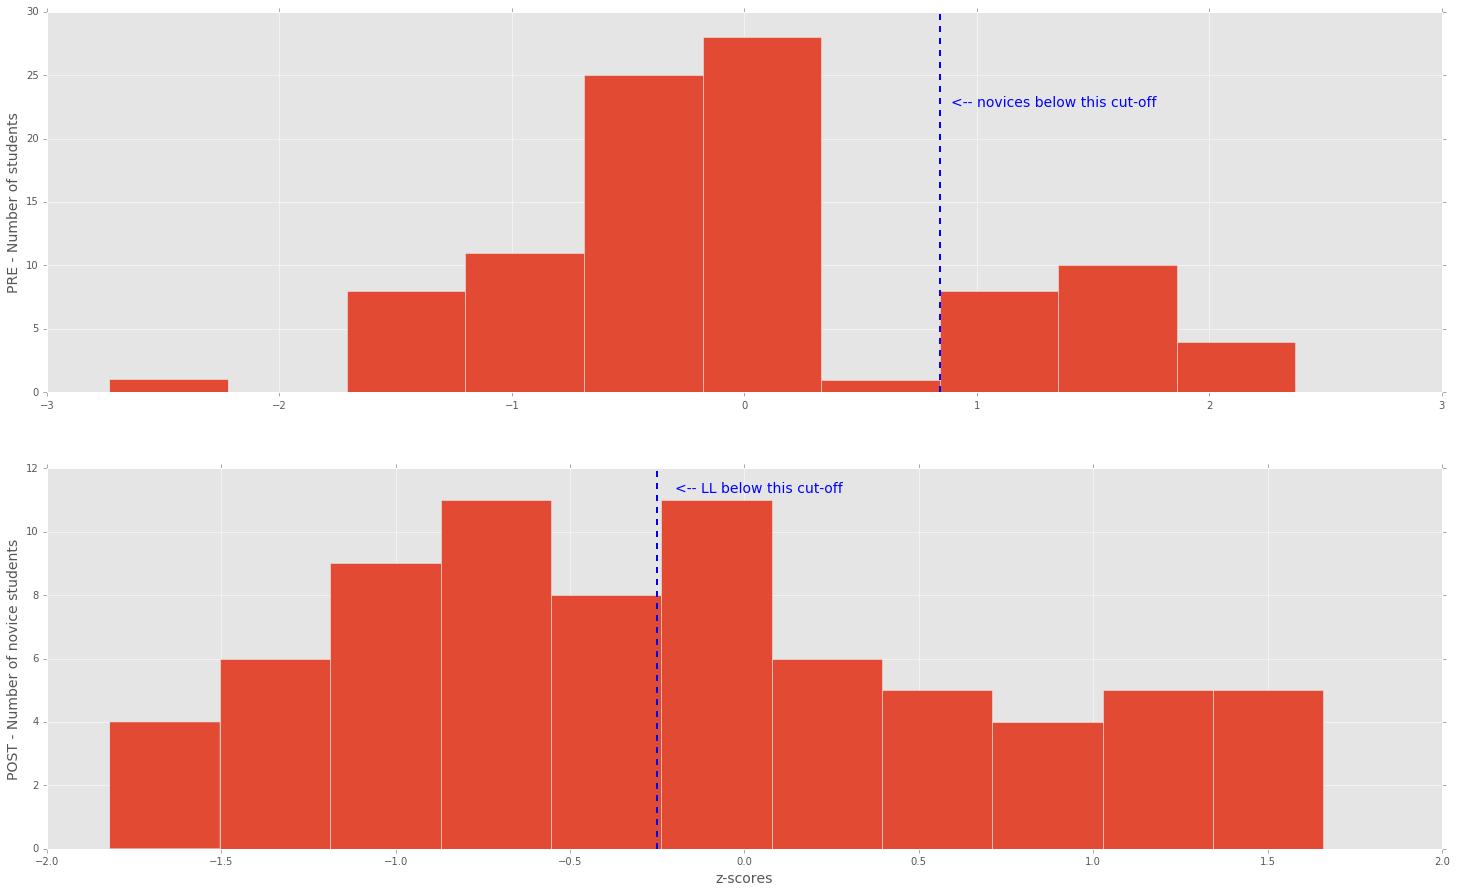

In [7]:
##plot pre-test z-scores
pre_scores = df_scores['z pre']
plt.subplot(2,1,1)
hpre = plt.hist(pre_scores)
plt.ylabel('PRE - Number of students', fontsize=14)
#cut-off for novices defined at minima in bimodal dist
cutoff = hpre[1][7]
plt.axvline(cutoff, ls = '--', lw = 2)
plt.text(cutoff+0.05, 22.5, '<-- novices below this cut-off', fontsize=14, color='blue')

##plot post-test z-scores of novices (as defined above)
post_scores_novices = df_scores['z post t2'][df_scores['z pre'] < cutoff]
plt.subplot(2,1,2)
hpost = plt.hist(post_scores_novices, bins=11)
plt.ylabel('POST - Number of novice students', fontsize=14)
plt.xlabel('z-scores', fontsize=14)
#cut-off for high vs low learning novice defined by median split
post_scores_novices_mdn = np.median(post_scores_novices)
plt.axvline(post_scores_novices_mdn, ls = '--', lw = 2)
plt.text(post_scores_novices_mdn+0.05, 11.25, '<-- LL below this cut-off', fontsize=14, color='blue')

##forming groups of students ID for LL, LH, HH and HL
students = df_scores['student']
novice_students = df_scores['student'][df_scores['z pre'] < cutoff]
low_post_students = df_scores['student'][df_scores['z post t2'] < post_scores_novices_mdn]
high_post_students = df_scores['student'][df_scores['z post t2'] >= post_scores_novices_mdn]
LL_students = list( set(novice_students) & set(low_post_students) )
LH_students = list( set(novice_students) - set(LL_students) )
HH_students = list( set(students) & set(high_post_students) - set(novice_students) )
HL_students = list( set(students) & set(low_post_students) - set(novice_students) )
print 'There are a total of {} novices of which LL={} and LH={}'.format(len(novice_students),len(LL_students), len(LH_students))
print 'There are a total of {} incoming experts of which HH={} and HL={}'.format(len(students)-len(novice_students),len(HH_students), len(HL_students))


## Action timeline plots

In [8]:
# For our analysis and for plotting here we are IGNORING the following action families: Interface and Test__other 
# THESE WILL APPEAR AS BLANKS IN TIMELINE WHEN THEY OCCUR IN A STUDENT'S ACTIVITY.
# Action families to plot:
pltFamilies = ['Construct','Pause','Test_basic','Test_simple','Test_complex']
#For publications and presentation we changed our naming scheme for the above considered action families to:
axis_labels =  ['Construct','Pause','Test_1','Test_2','Test_m',]

### Low to high scores

In [9]:
df_scores.loc[df_scores['student'].isin(LH_students)][['student','z pre','z post t2']]

,student,z pre,z post t2
0,1075123,-1.52,0.33
1,3591123,0.19,-0.12
6,8775127,-0.54,1.03
10,10942128,0.19,-0.23
12,12949120,-0.06,0.59
14,13378139,-0.06,1.03
20,18088102,-0.54,-0.18
27,24387118,-0.54,-0.23
28,24582121,-1.52,-0.25
31,28582129,-0.54,-0.23


In [10]:
# pick a student from above group
student = 86170104
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student]  

pre --> post
-0.54 --> 1.59


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
85,July,not,3,3,0,0,1,1,1,0,0,0.38,0.94,0.88,0.75,0.57,-0.54,0.94,1.59,2.11,2.33,2.44,3.5,2.75,attitude,notscaffolded_attitude,86170104,-1519298477


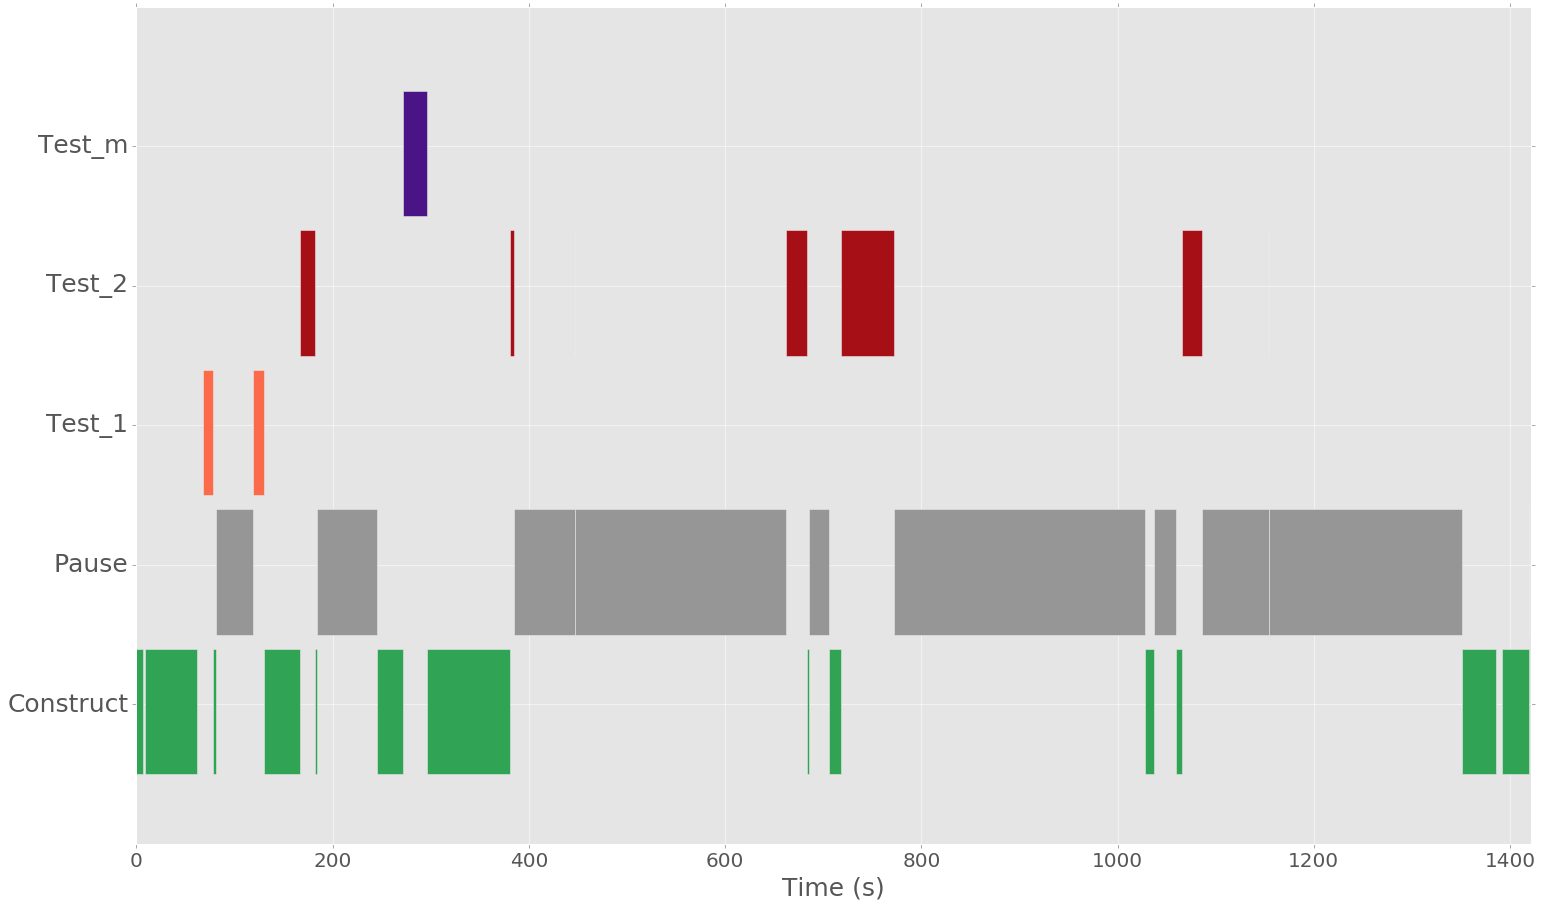

In [11]:
plot_barGraph_new(dfx,'a2', 86170104, pltFamilies, axis_labels)  

In [12]:
# pick a student from above group
student = 1075123
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student]  

pre --> post
-1.52 --> 0.33


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
0,March,scaff,2,2,0,0,1,1,1,0,0,0.21,-0.42,0.64,0.79,0.75,-1.52,-0.42,0.33,2.67,2.78,2.67,4.0,3.5,attitude,scaffolded_attitude,1075123,1920143974


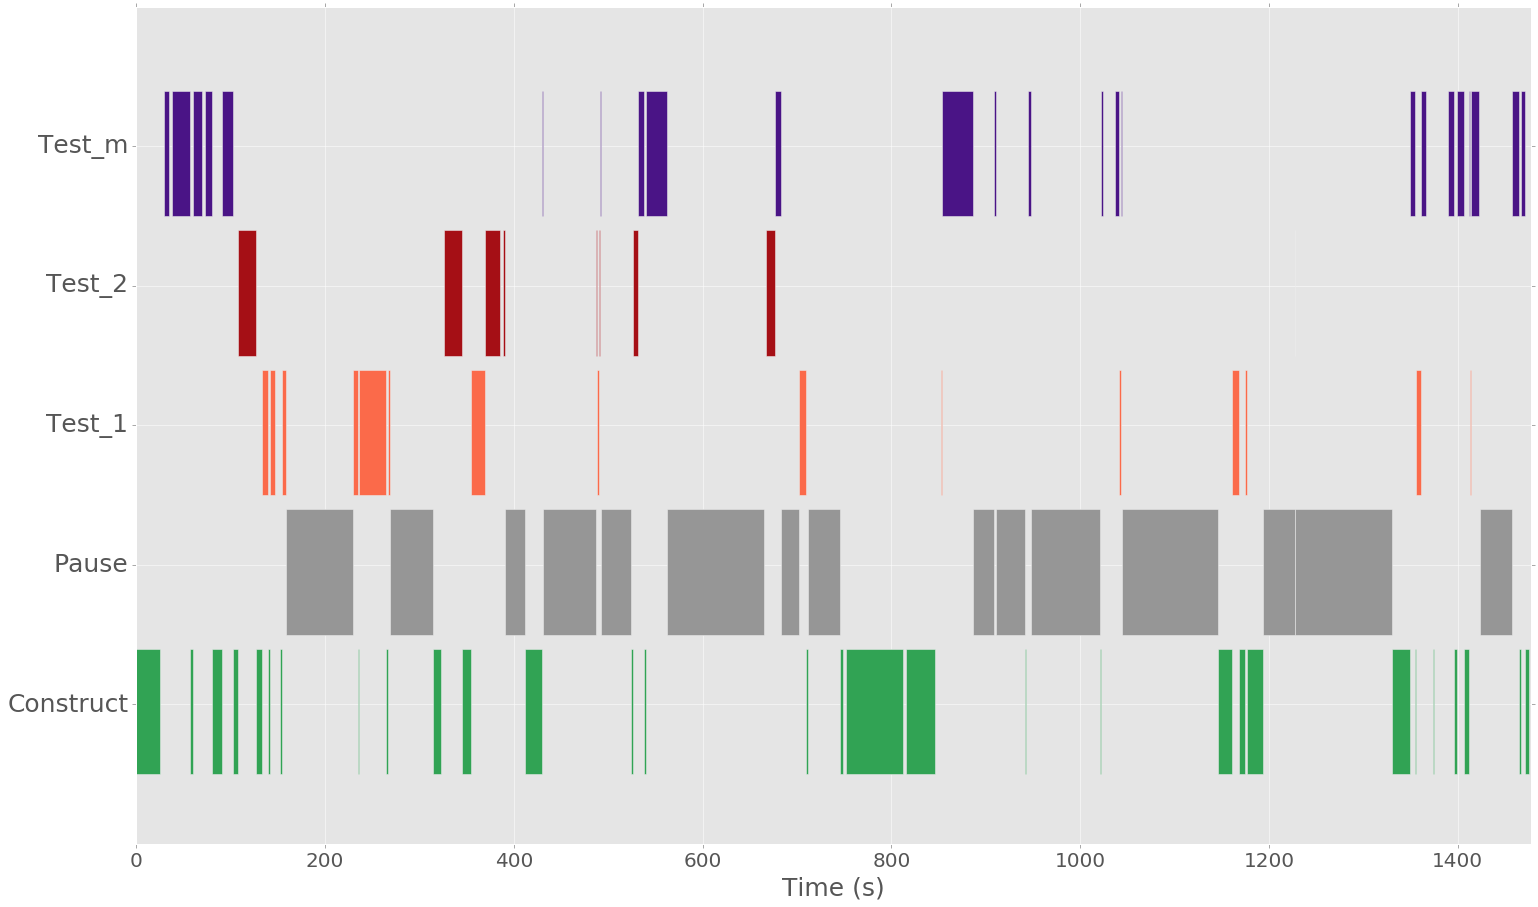

In [13]:
plot_barGraph_new(dfx,'a2', 1075123, pltFamilies, axis_labels)  

In [14]:
# pick a student from above group
student = 96314111
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student]  

pre --> post
-2.73 --> 1.66


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
95,March,not,3,2,1,1,1,1,1,1,1,0.0,0.84,0.89,1.0,1.65,-2.73,0.84,1.66,2.67,3.0,2.89,4.0,3.25,attitude,notscaffolded_attitude,96314111,2030580754


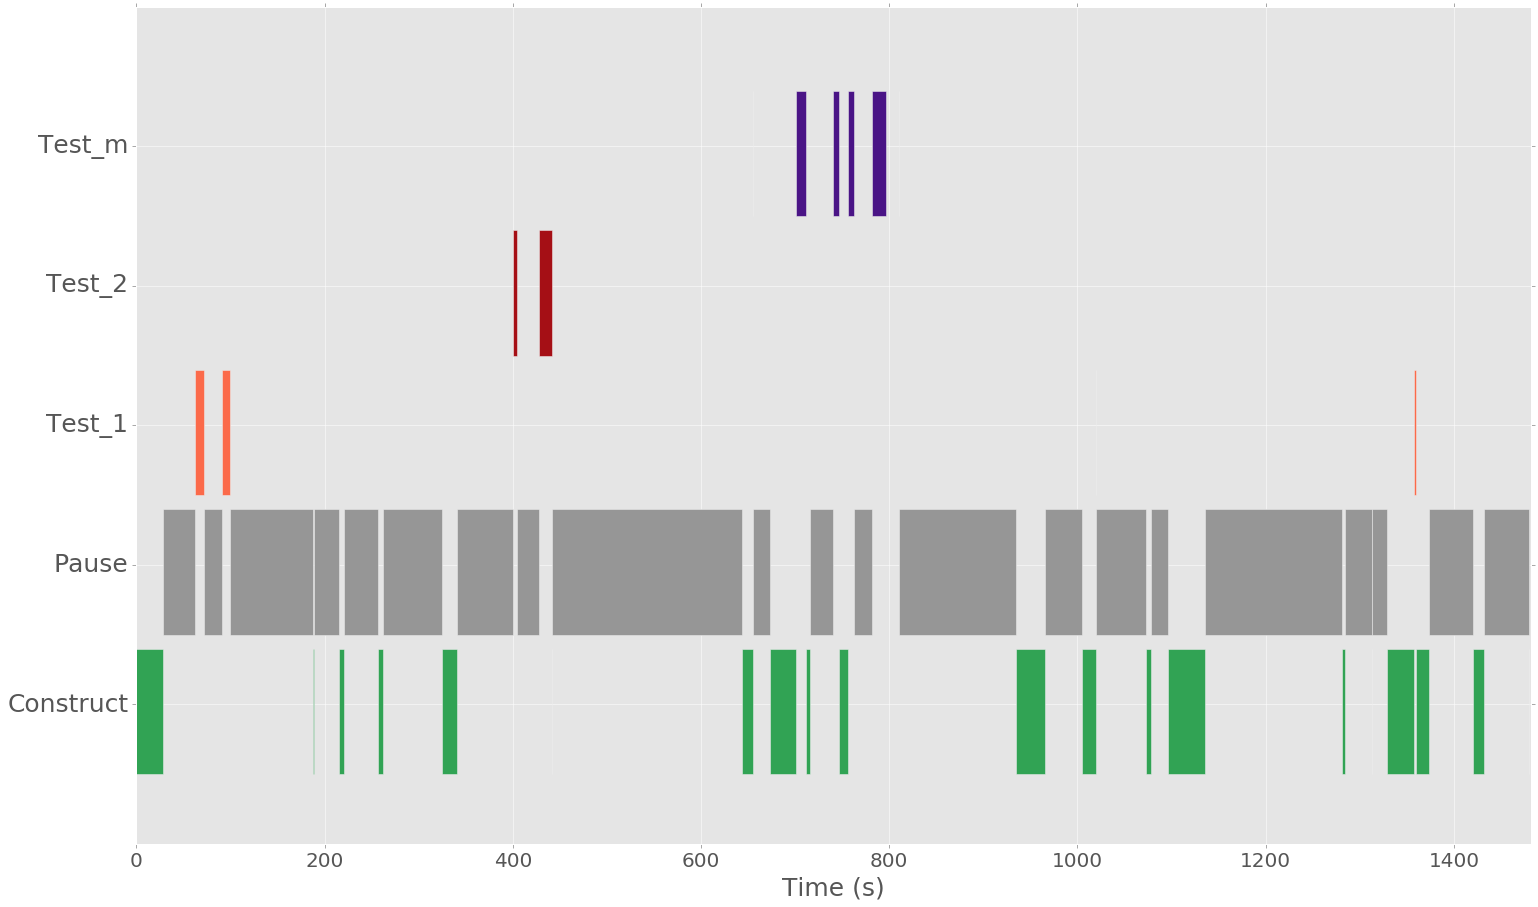

In [15]:
plot_barGraph_new(dfx,'a2', 96314111, pltFamilies, axis_labels)  

In [16]:
# pick a student from above group
student = 83841128
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student]  

pre --> post
-1.52 --> 1.03


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
81,March,not,2,2,1,1,0,1,1,2,1,0.21,1.34,0.77,0.92,1.29,-1.52,1.34,1.03,2.44,2.0,2.11,4.0,2.5,attitude,notscaffolded_attitude,83841128,1733023399


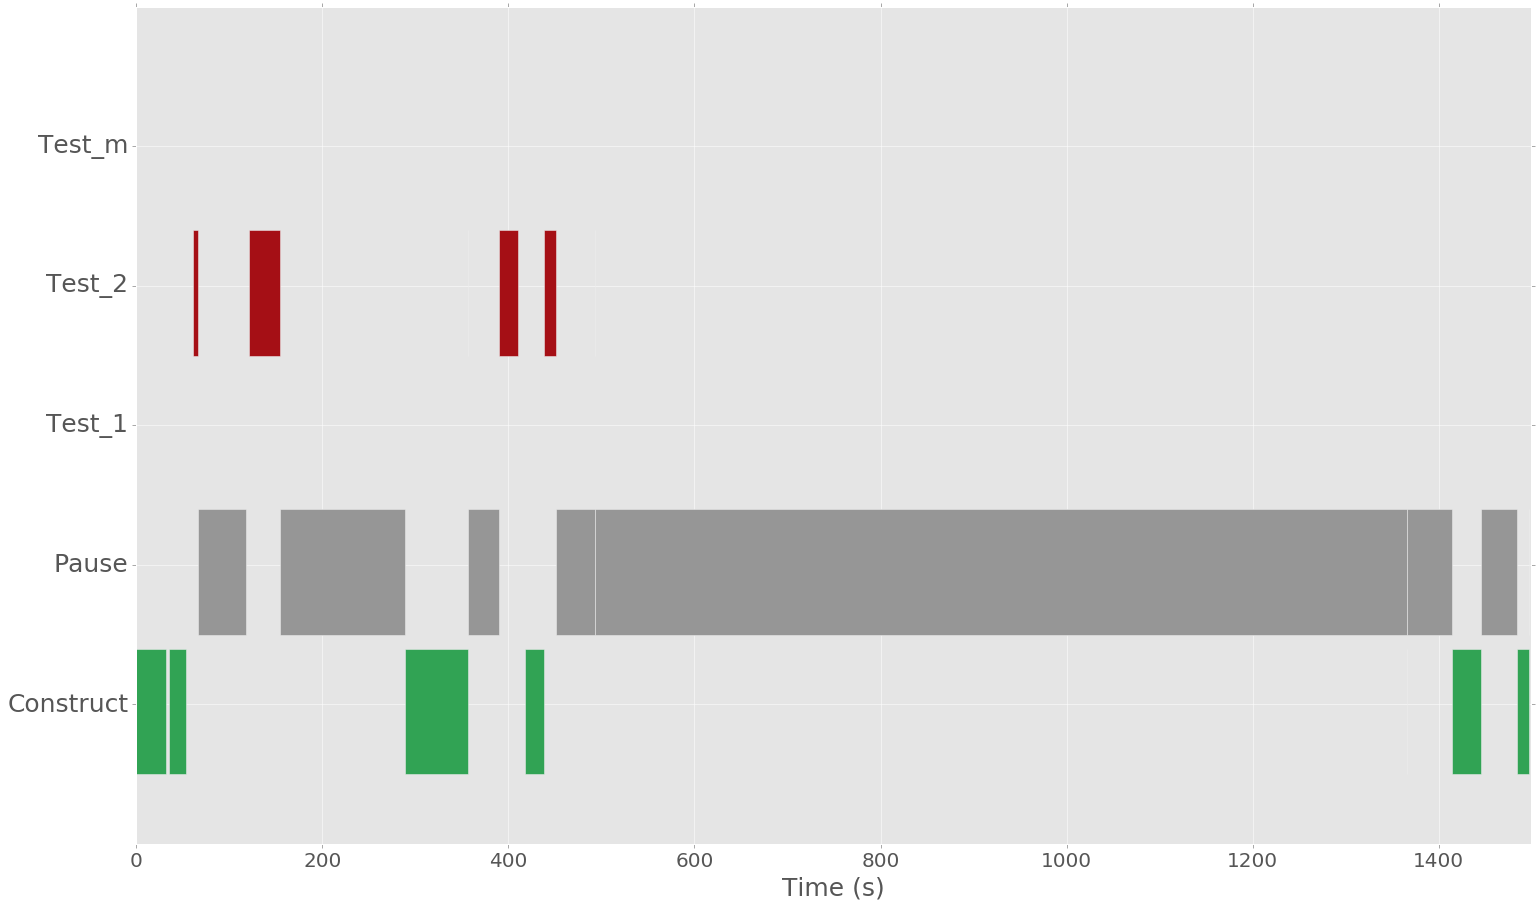

In [17]:
plot_barGraph_new(dfx,'a2', 83841128, pltFamilies, axis_labels)  

In [18]:
# pick a student from above group
student = 42175126
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student]  

pre --> post
-1.03 --> 0.59


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
41,July,scaff,2,2,0,0,1,0,1,0,0,0.29,-0.09,0.69,0.75,0.57,-1.03,-0.09,0.59,2.33,2.89,2.22,4.0,3.25,attitude,scaffolded_attitude,42175126,1058332740


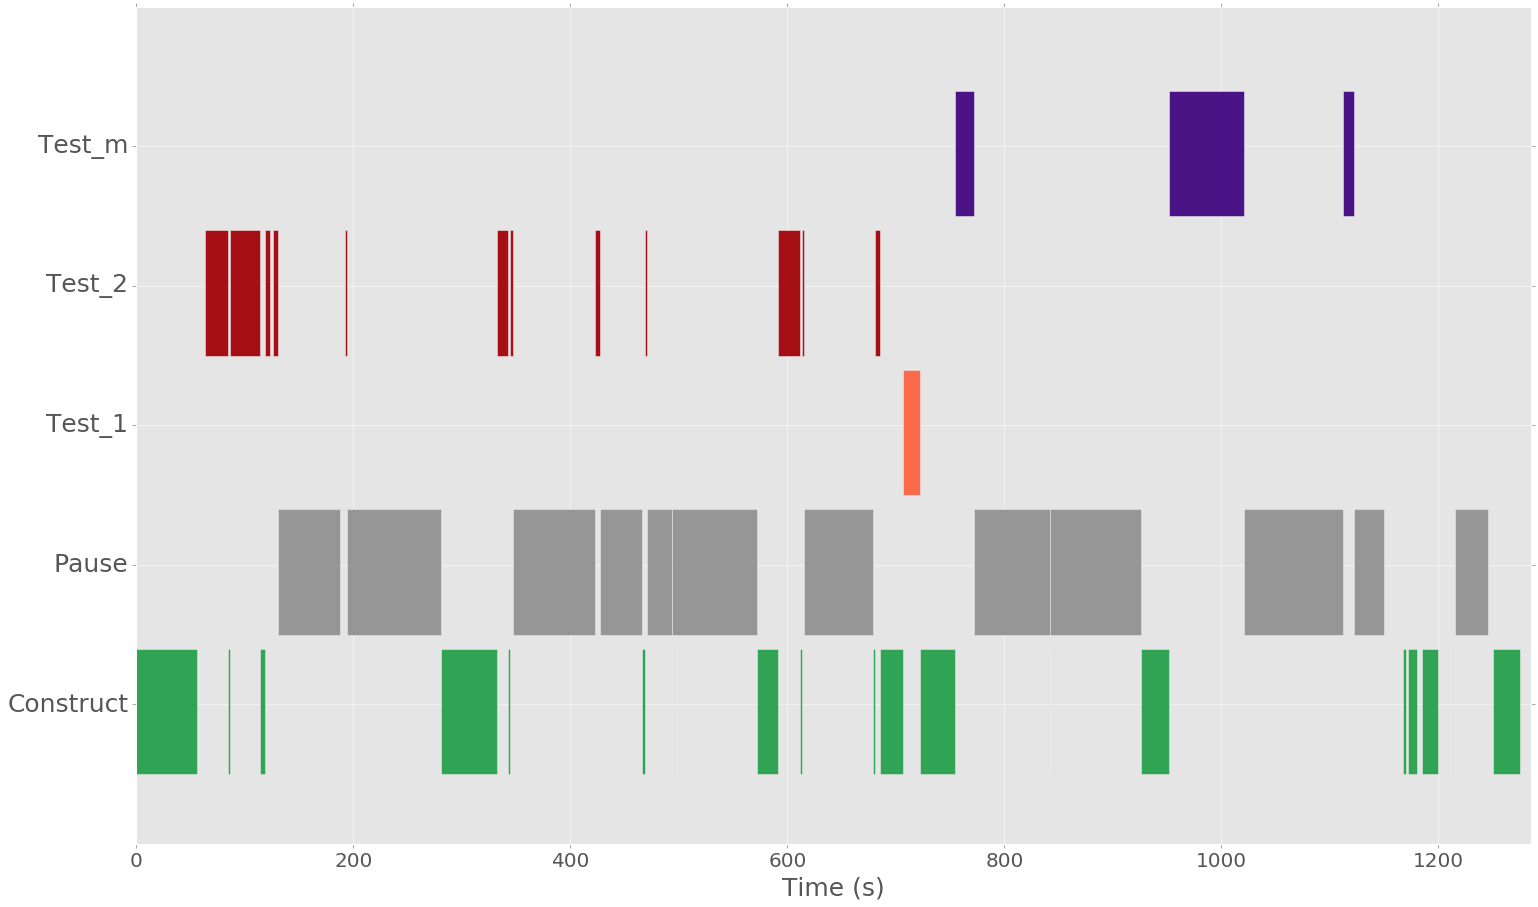

In [19]:
plot_barGraph_new(dfx,'a2', 42175126, pltFamilies, axis_labels)  #another low to high z-scores

In [20]:
# pick a student from above group
student = 38732121
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -0.07


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
37,March,scaff,3,3,0,0,0,1,1,0,0,0.5,0.58,0.56,0.88,1.11,0.19,0.58,-0.07,2.78,3.44,3.22,4.0,3.75,attitude,scaffolded_attitude,38732121,-1133164261


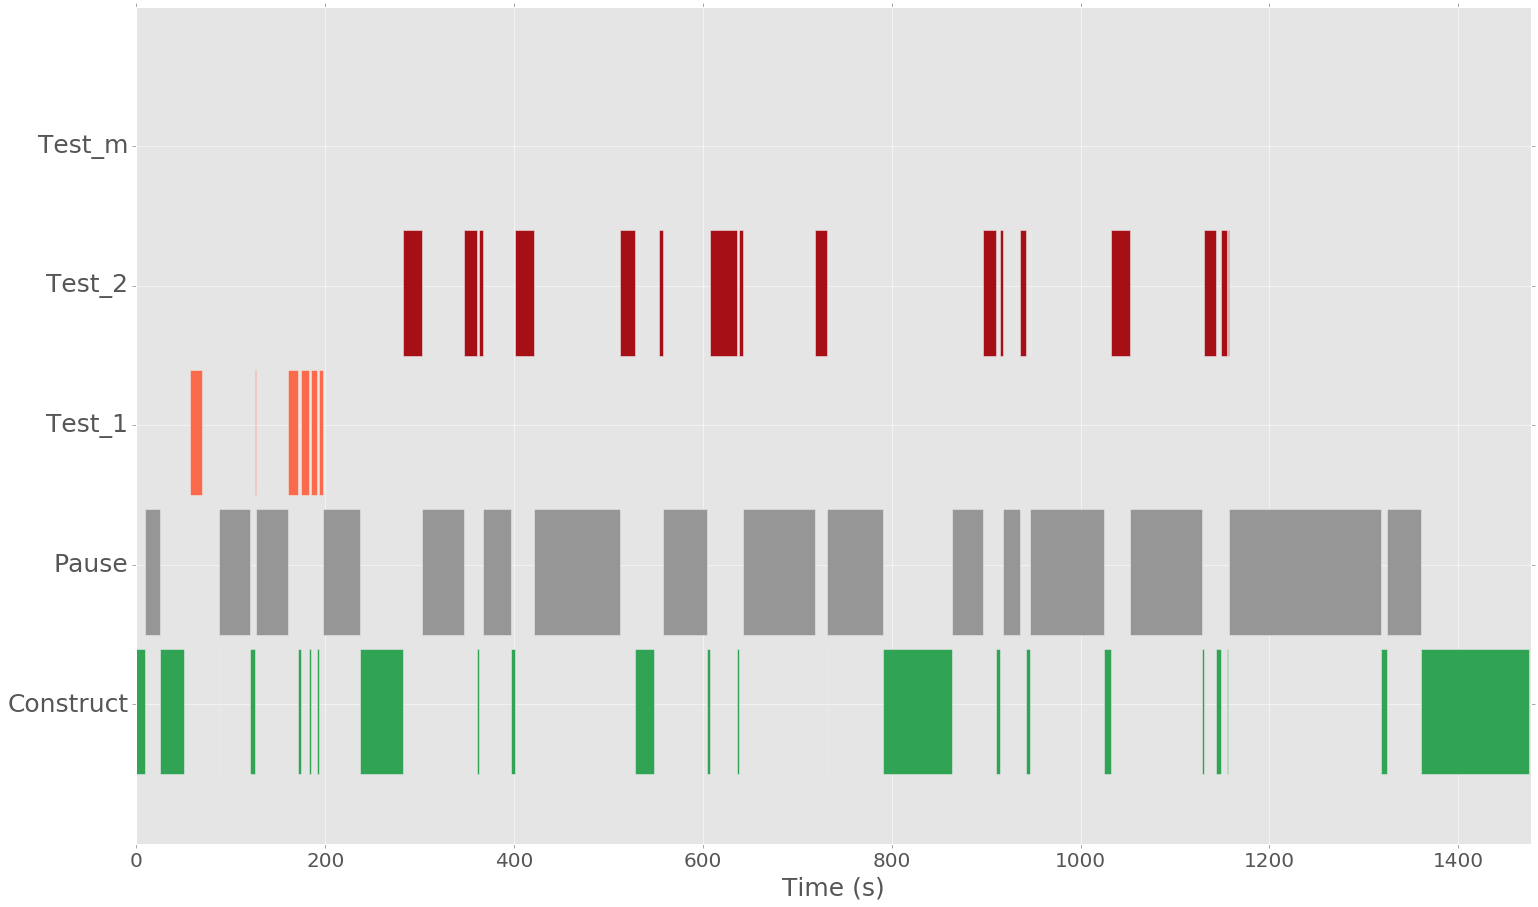

In [21]:
plot_barGraph_new(dfx,'a2', 38732121, pltFamilies, axis_labels)  #another low to high z-scores

In [22]:
# pick a student from above group
student = 37842114
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> 0.81


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
34,July,scaff,1,2,0,1,1,1,1,2,1,0.5,0.73,0.73,0.83,0.93,0.19,0.73,0.81,2.11,2.67,2.89,4.0,2.25,knowledge,scaffolded_knowledge,37842114,691235518


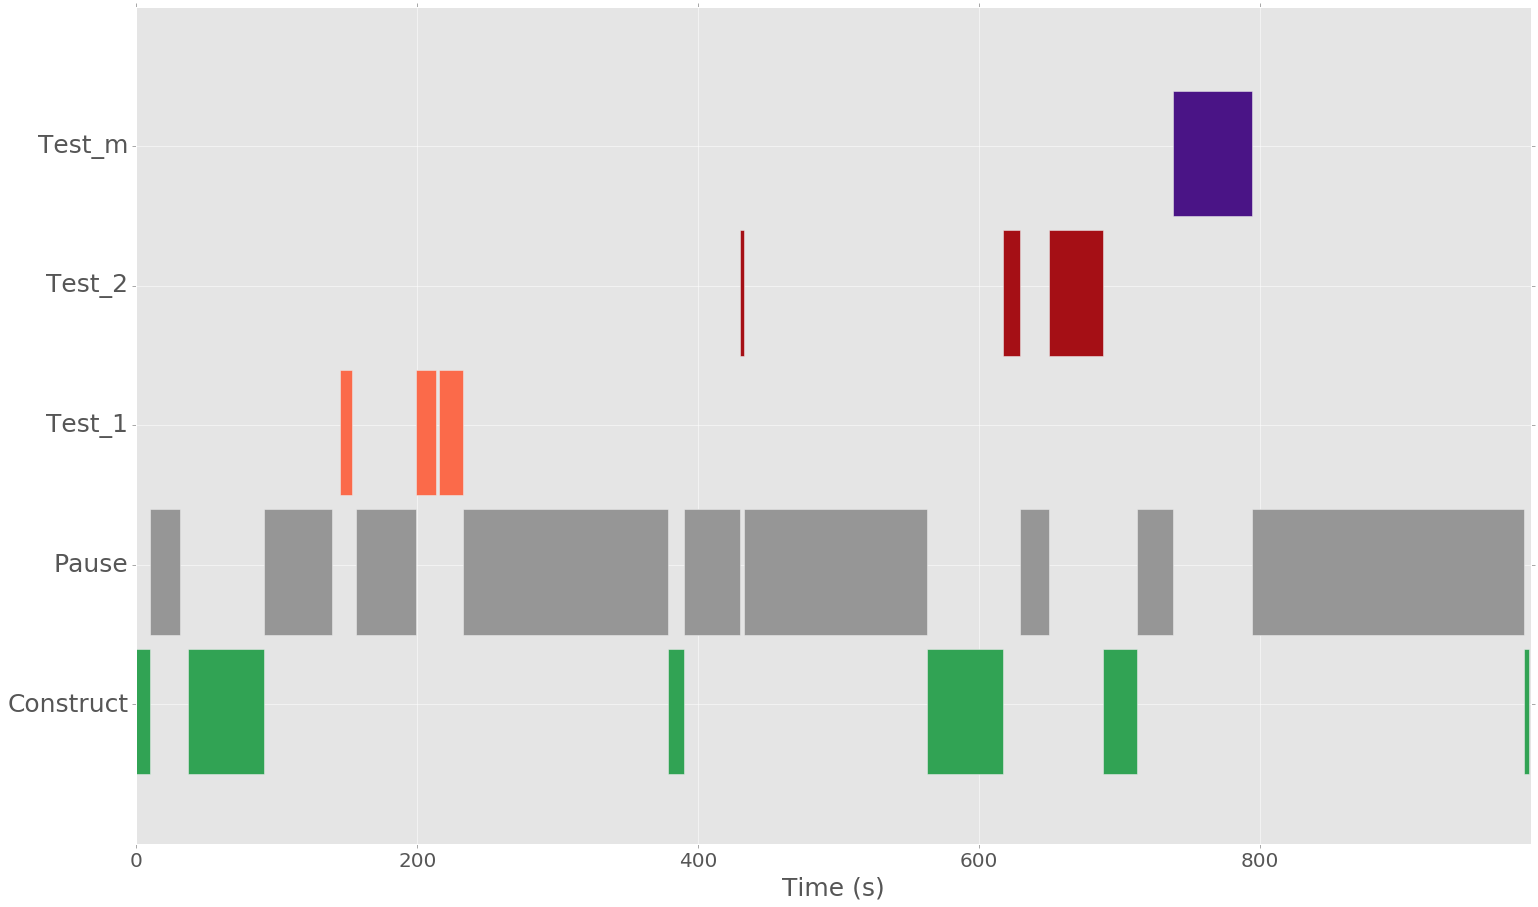

In [23]:
plot_barGraph_new(dfx,'a2', 37842114, pltFamilies, axis_labels)  #another low to high z-scores

In [24]:
# pick a student from above group
student = 51876107
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> 0.92


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
48,July,not,2,2,1,0,0,1,1,0,0,0.38,1.56,0.75,0.88,1.11,-0.54,1.56,0.92,2.78,2.33,2.56,4.0,2.25,attitude,notscaffolded_attitude,51876107,1836024689


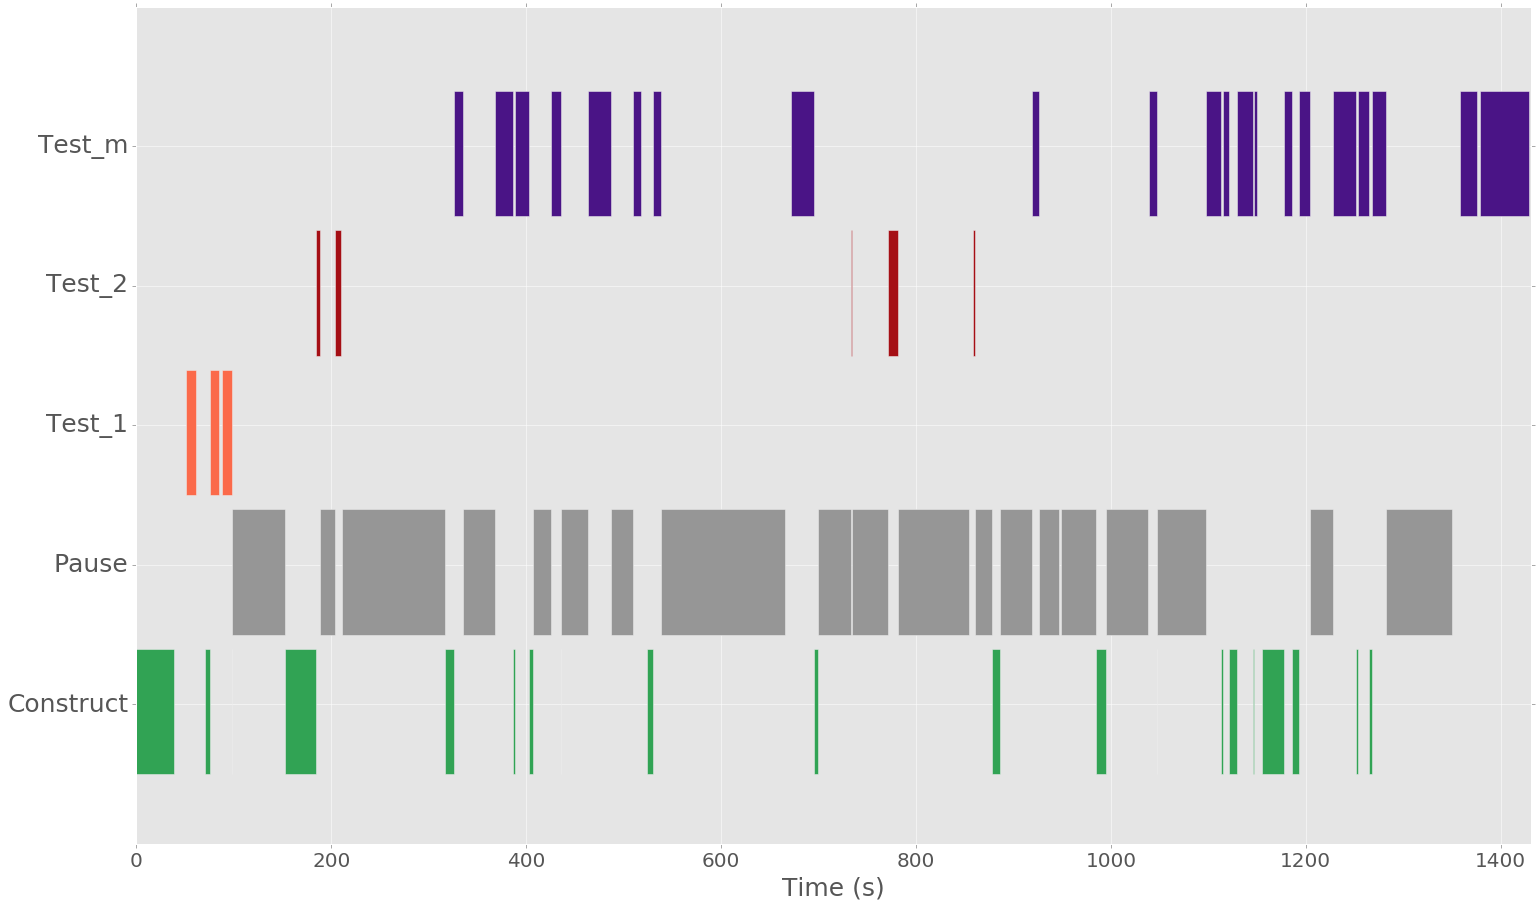

In [25]:
plot_barGraph_new(dfx,'a2', 51876107, pltFamilies, axis_labels)  #another low to high z-scores

### Low to low scores

In [26]:
df_scores.loc[df_scores['student'].isin(LL_students)][['student','z pre','z post t2']]

,student,z pre,z post t2
2,3932129,-0.30,-0.72
3,4762120,0.43,-1.18
7,8889108,-1.52,-1.62
8,9331415,-0.54,-1.49
9,10009106,-0.06,-0.91
11,12235124,-0.79,-1.40
16,14769115,-0.54,-0.80
18,17070059,0.19,-0.78
22,18893119,0.19,-1.07
23,19930112,-1.27,-1.18


In [27]:
# pick a student from above group
student = 8889108
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-1.52 --> -1.62


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
7,July,scaff,1,3,0,0,1,1,1,0,0,0.21,-0.72,0.27,0.21,-1.79,-1.52,-0.72,-1.62,2.67,2.33,2.33,2.0,3.25,attitude,scaffolded_attitude,8889108,1140619053


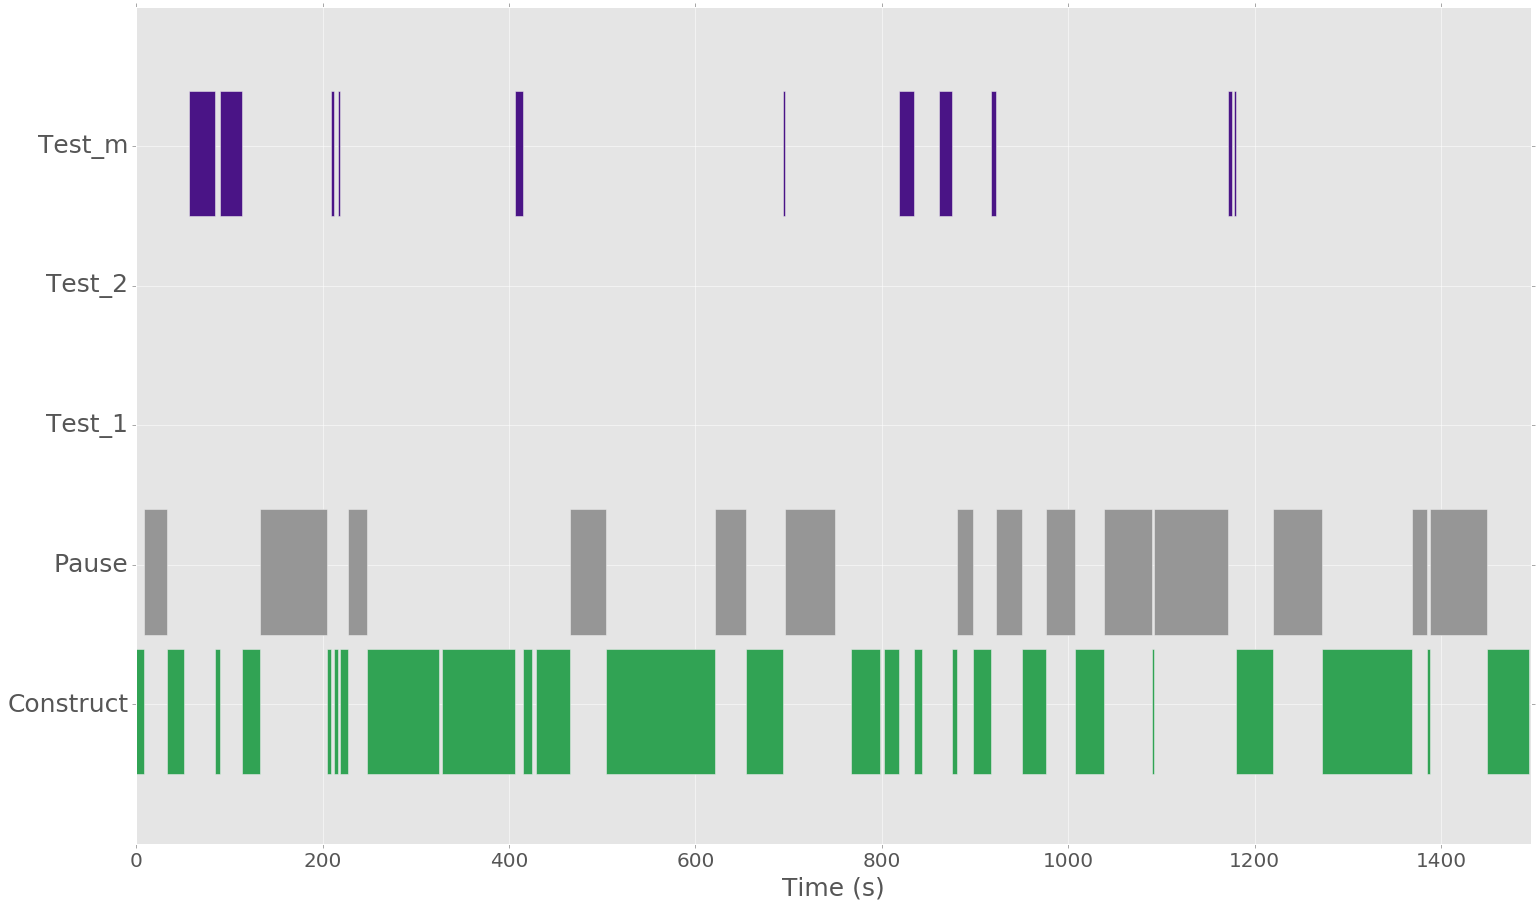

In [28]:
plot_barGraph_new(dfx,'a2', 8889108, pltFamilies, axis_labels)  #low low z-scores

In [29]:
# pick a student from above group
student = 19930112
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-1.27 --> -1.18


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
23,July,not,2,2,1,0,1,0,1,0,0,0.25,0.11,0.35,0.71,0.38,-1.27,0.11,-1.18,3.0,3.11,3.0,5.0,3.25,attitude,notscaffolded_attitude,19930112,1049426630


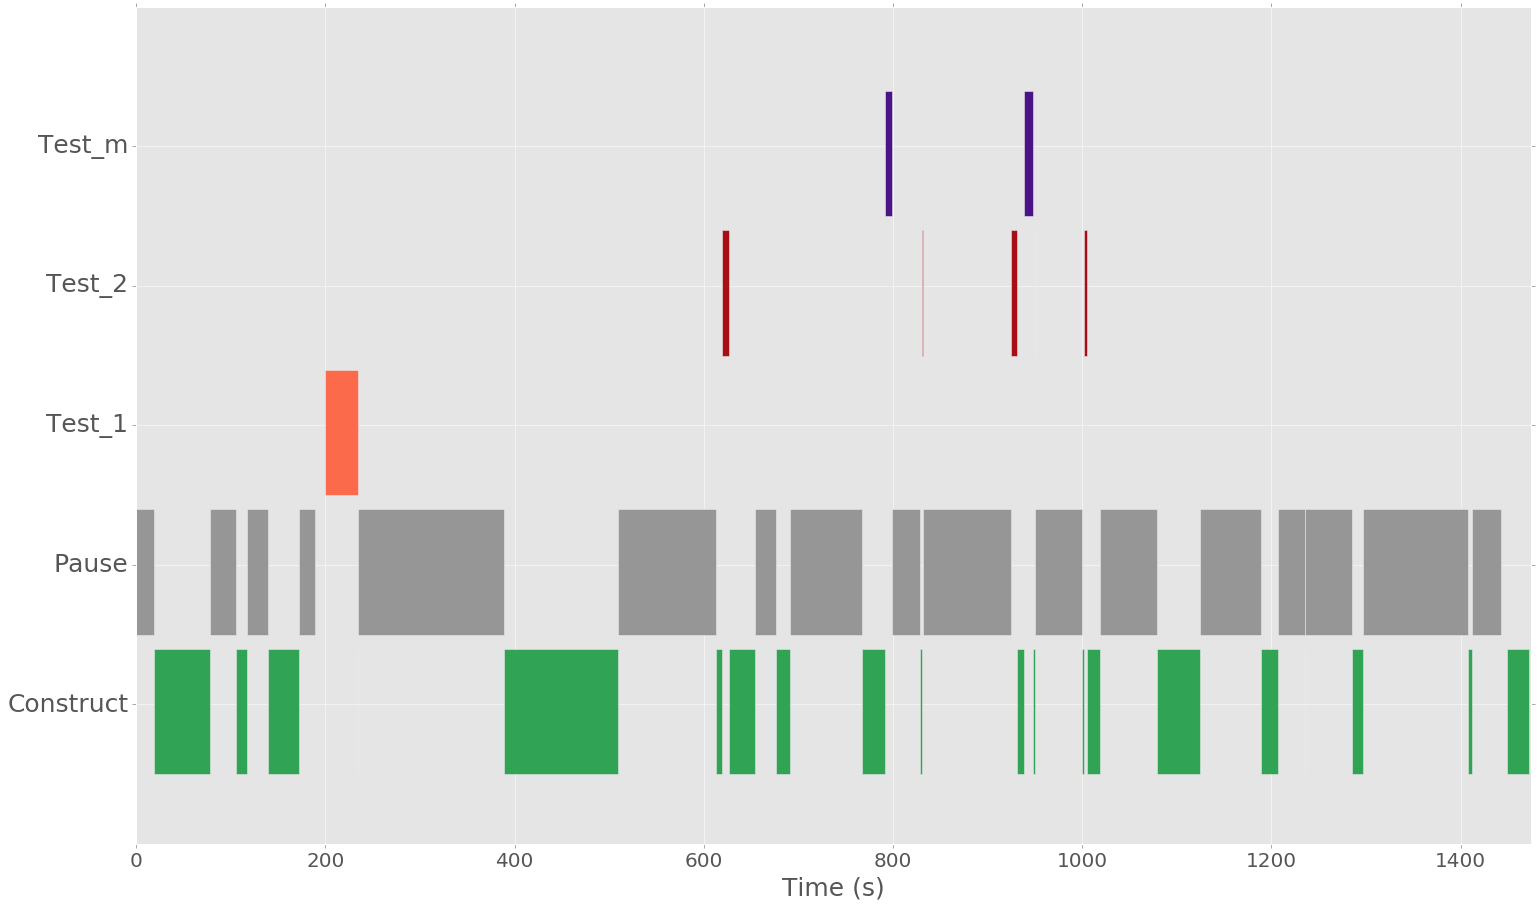

In [30]:
plot_barGraph_new(dfx,'a2', 19930112, pltFamilies, axis_labels)  #low low z-scores

In [31]:
# pick a student from above group
student = 61117124
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -0.25


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
54,March,scaff,1,2,0,1,1,0,1,1,0,0.5,-0.42,0.53,0.63,0.02,0.19,-0.42,-0.25,2.78,2.78,2.89,4.0,3.0,attitude,scaffolded_attitude,61117124,1790618331


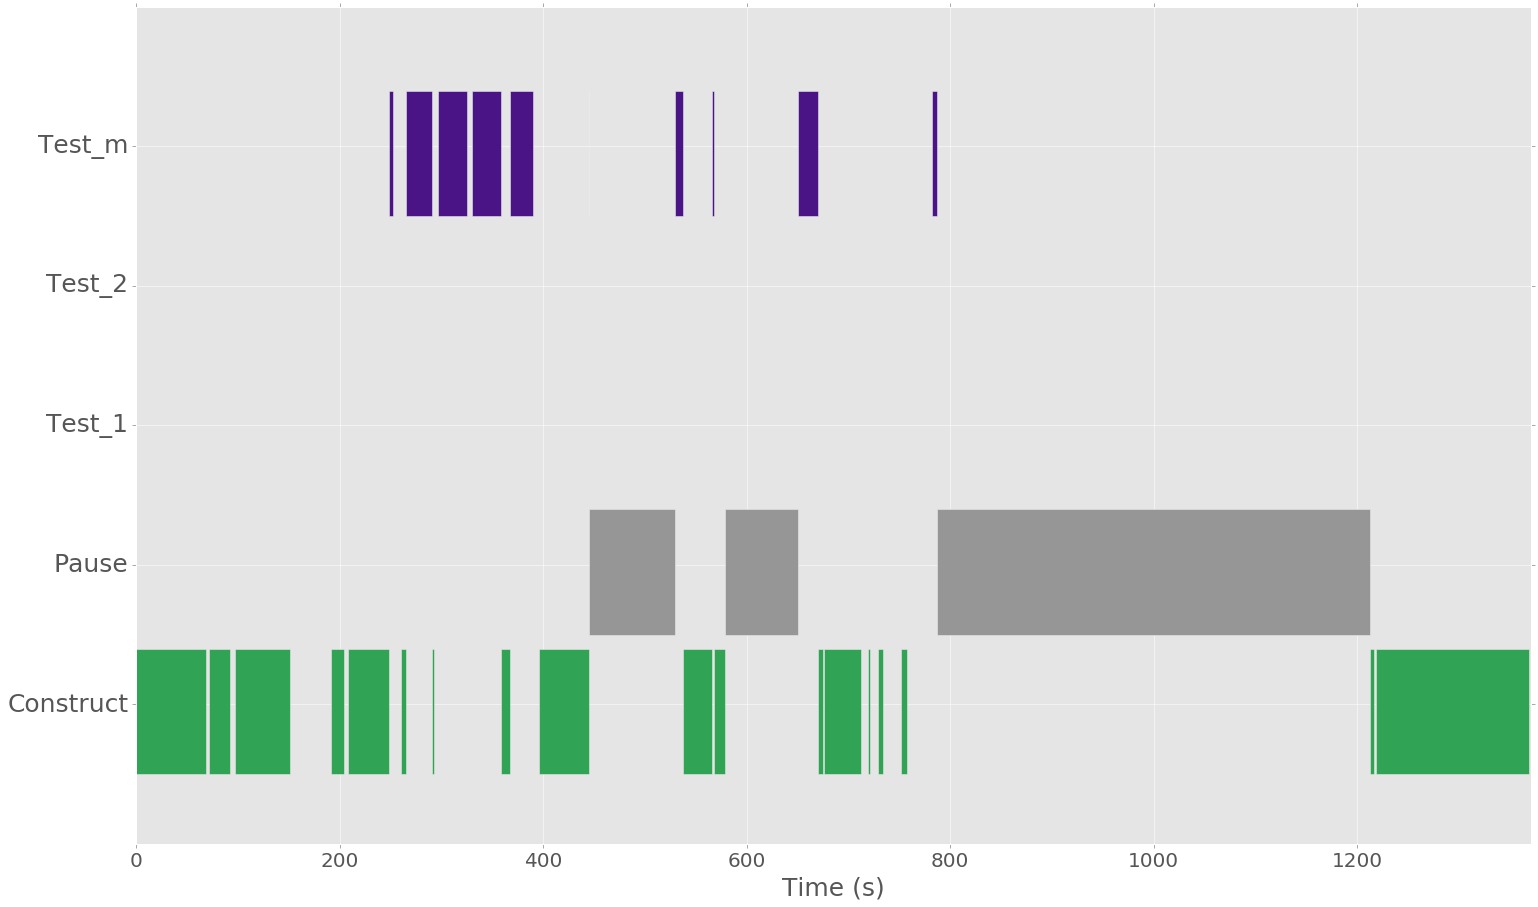

In [32]:
plot_barGraph_new(dfx,'a2', 61117124, pltFamilies, axis_labels)  #low low z-scores

In [33]:
# pick a student from above group
student = 35155125
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> -1.0


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
33,March,scaff,2,2,0,1,1,0,1,1,1,0.38,-2.18,0.39,0.42,-0.88,-0.54,-2.18,-1.0,3.11,3.33,2.89,4.0,2.75,attitude,scaffolded_attitude,35155125,1058442939


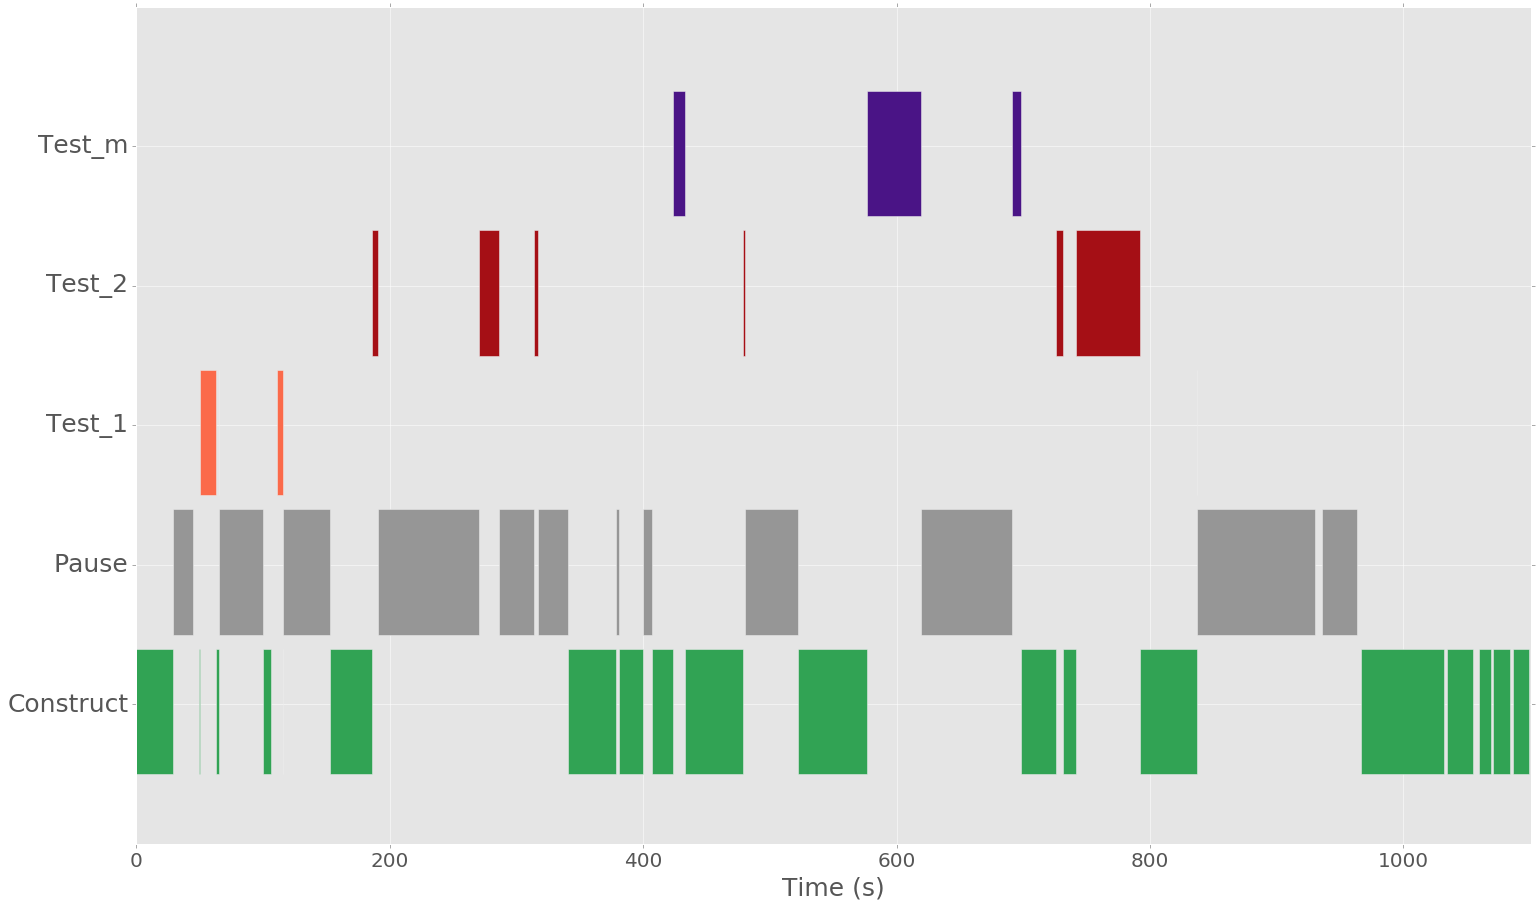

In [34]:
plot_barGraph_new(dfx,'a2', 35155125, pltFamilies, axis_labels)  #low low z-scores

In [35]:
# pick a student from above group
student = 82616120
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -0.38


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
77,March,not,2,3,0,1,1,1,1,1,0,0.5,-0.92,0.5,0.5,-0.52,0.19,-0.92,-0.38,3.11,3.11,3.0,4.0,3.25,attitude,notscaffolded_attitude,82616120,182447960


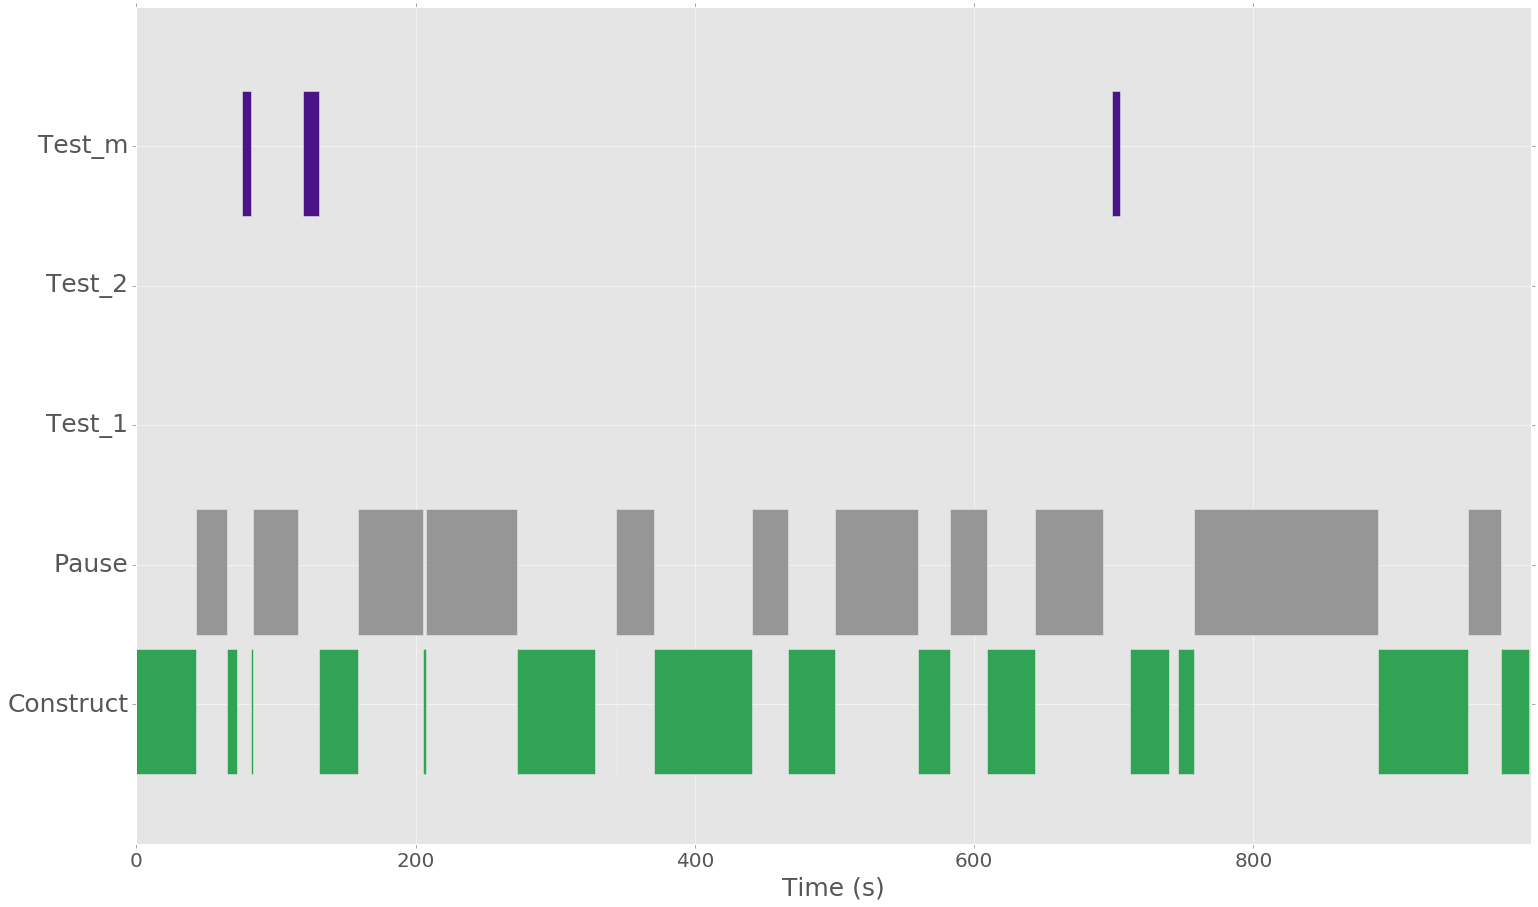

In [36]:
plot_barGraph_new(dfx,'a2', 82616120, pltFamilies, axis_labels)  #low low z-scores

In [37]:
# pick a student from above group
student = 51352592
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-1.52 --> -0.38


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
47,March,scaff,3,2,1,1,0,0,1,0,0,0.21,-0.17,0.5,0.5,-0.52,-1.52,-0.17,-0.38,2.56,2.78,2.33,4.0,3.0,attitude,scaffolded_attitude,51352592,7106080


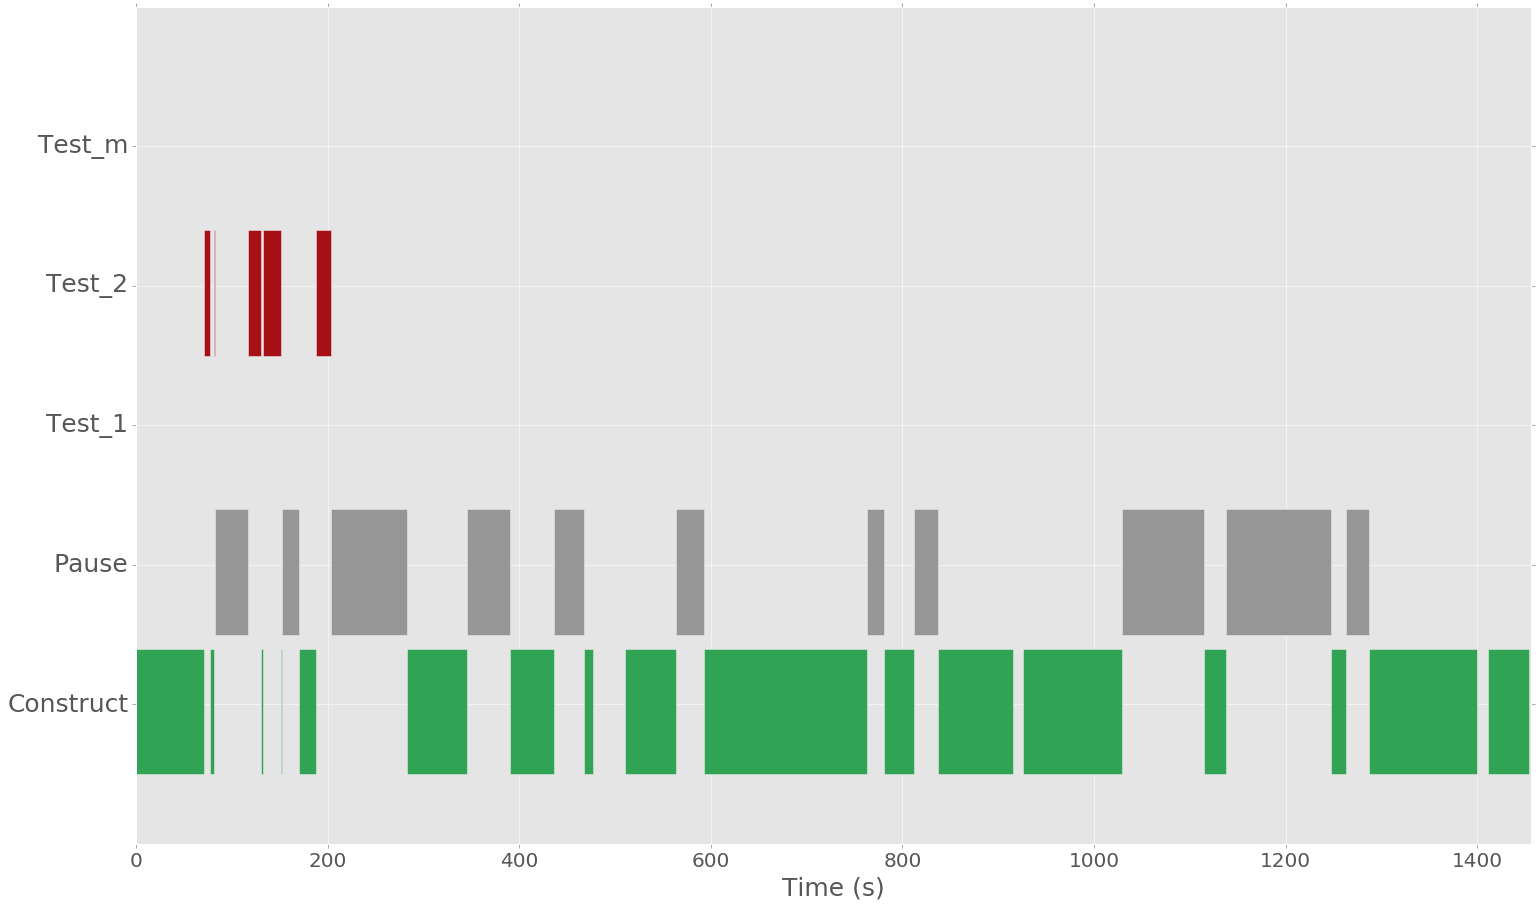

In [38]:
plot_barGraph_new(dfx,'a2', 51352592, pltFamilies, axis_labels)  #low low z-scores

### High to high scores

In [39]:
df_scores.loc[df_scores['student'].isin(HH_students)][['student','z pre','z post t2']]

,student,z pre,z post t2
4,4936123,0.92,-0.18
5,8580120,1.64,1.79
13,13205111,1.64,-0.14
15,13679110,0.92,1.99
17,15616121,0.92,0.70
19,17580122,2.37,0.48
21,18838125,1.64,1.72
24,20717120,0.92,0.26
30,28098102,1.64,1.19
35,37987123,2.37,0.66


In [40]:
# pick a student from above group
student = 8580120
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> 1.79


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
5,March,scaff,2,3,0,1,1,1,1,0,0,0.75,0.58,0.91,1.0,1.65,1.64,0.58,1.79,2.78,2.78,2.89,4.0,3.0,knowledge,scaffolded_knowledge,8580120,1682116183


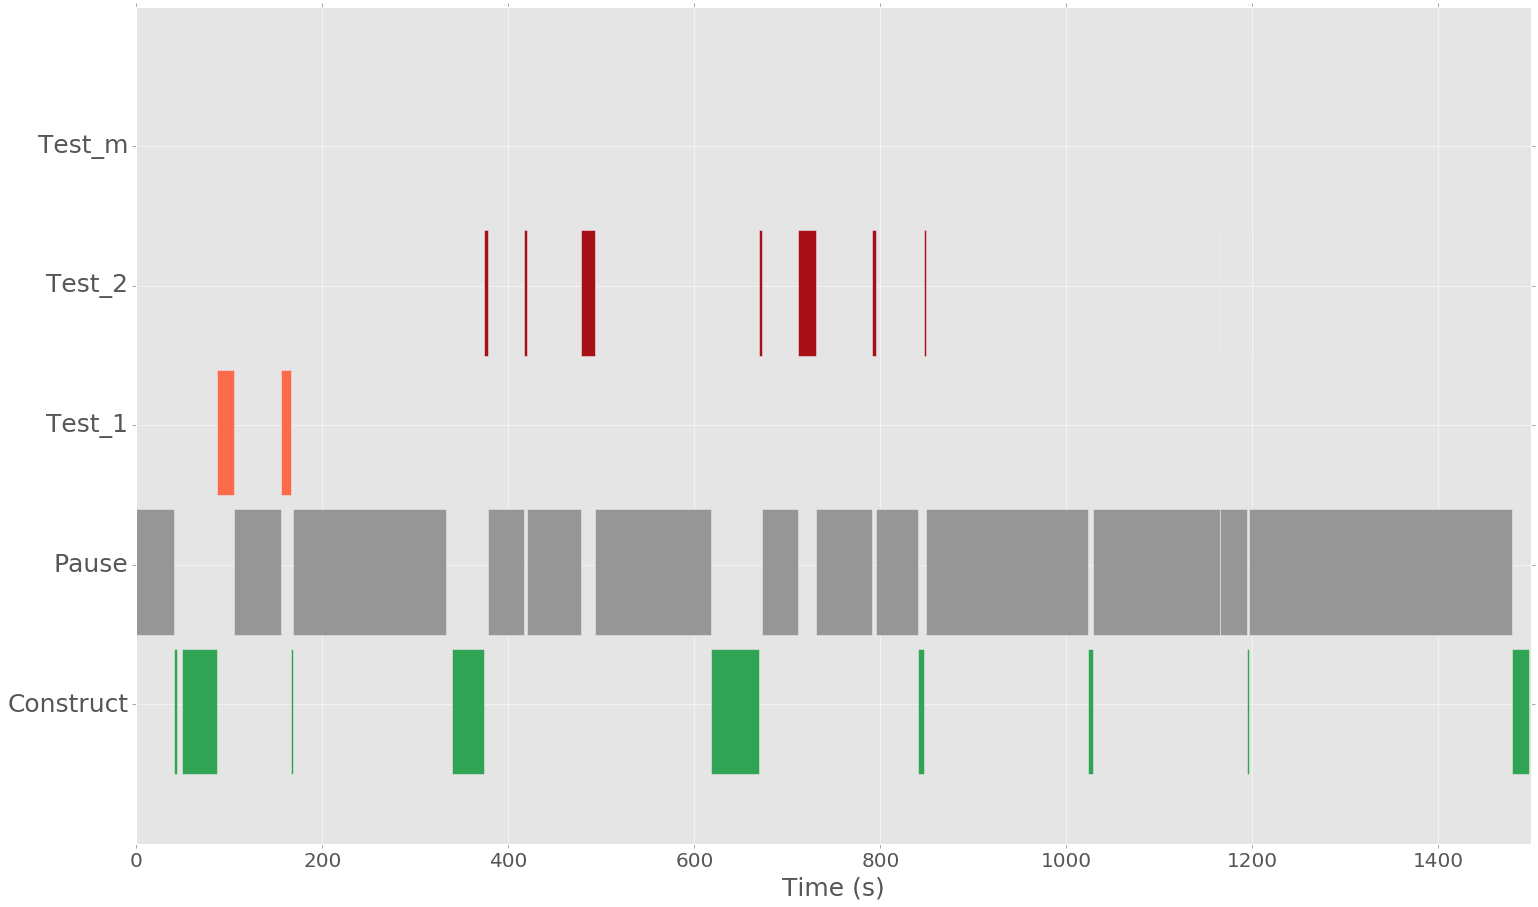

In [41]:
plot_barGraph_new(dfx,'a2',8580120, pltFamilies, axis_labels) #high high z-scores

In [42]:
# pick a student from above group
student = 18838125
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> 1.72


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
21,July,scaff,3,3,0,1,1,1,1,1,0,0.75,0.53,0.9,1.0,1.65,1.64,0.53,1.72,3.11,2.67,3.33,5.0,3.5,knowledge,scaffolded_knowledge,18838125,-1070897970


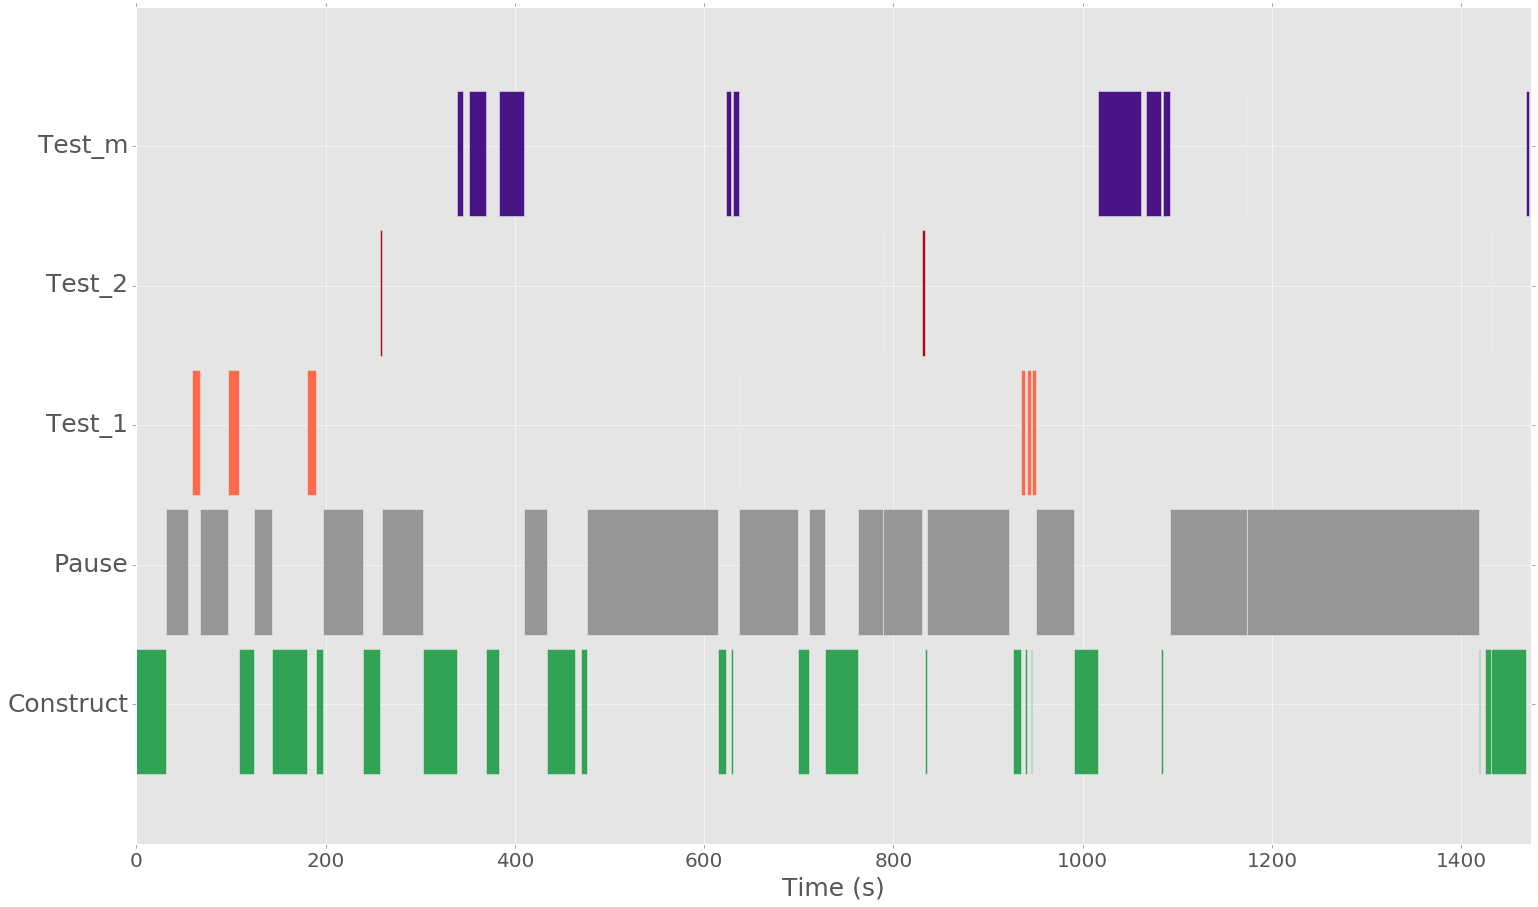

In [43]:
plot_barGraph_new(dfx,'a2',18838125, pltFamilies, axis_labels) #high high z-scores

In [44]:
# pick a student from above group
student = 28098102
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> 1.19


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
30,July,not,0,2,0,0,1,1,1,0,0,0.75,0.11,0.8,0.75,0.57,1.64,0.11,1.19,2.44,3.33,3.44,2.5,2.5,knowledge,notscaffolded_knowledge,28098102,1974924828


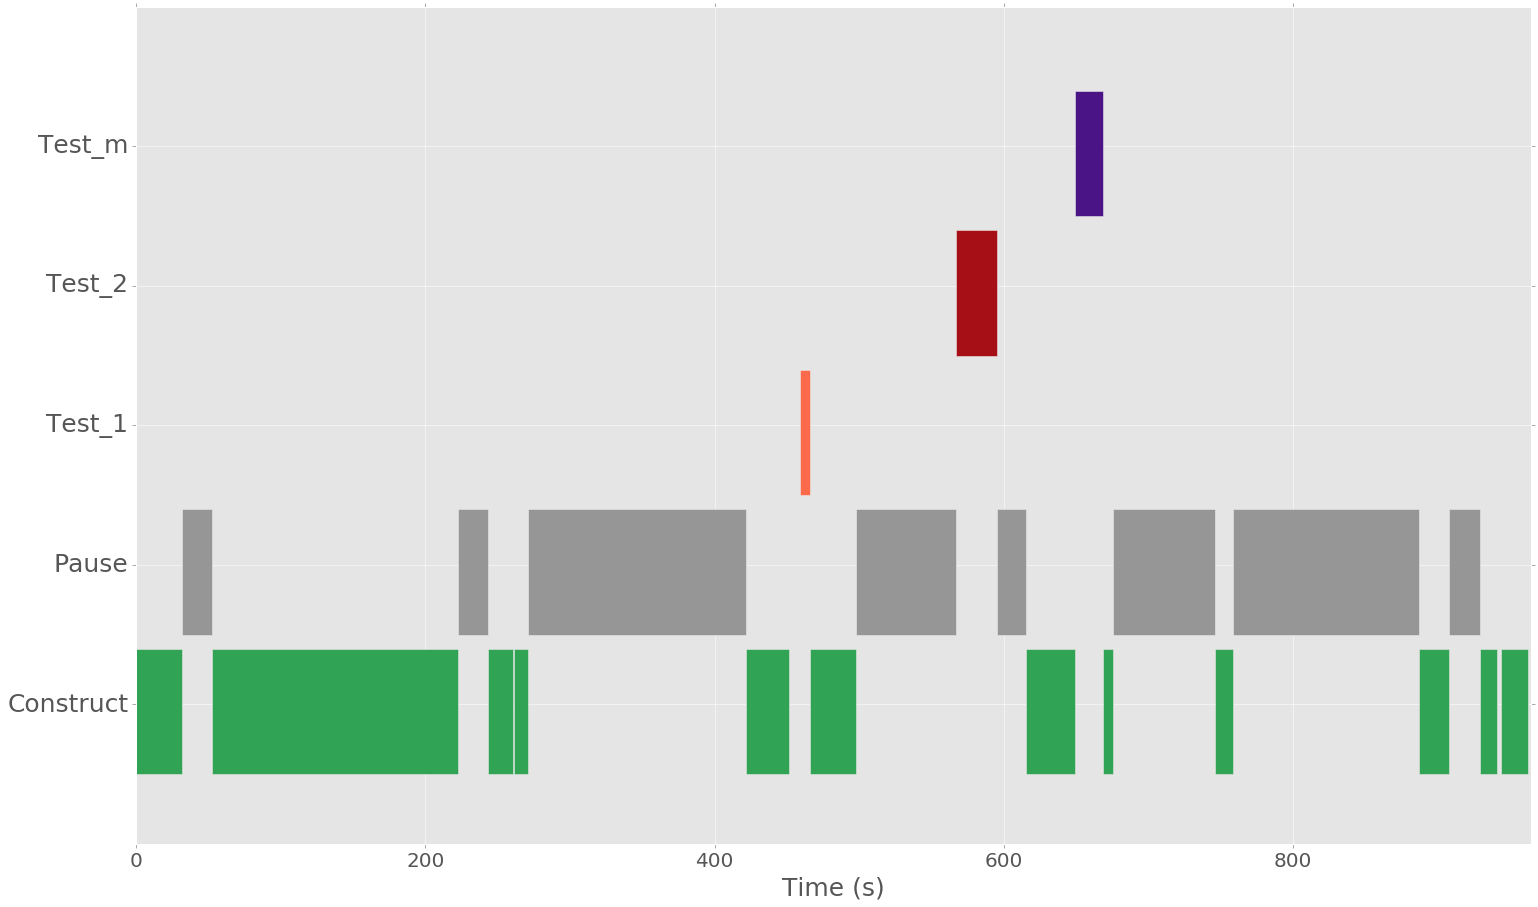

In [45]:
plot_barGraph_new(dfx,'a2',28098102, pltFamilies, axis_labels) #high high z-scores

In [46]:
# pick a student from above group
student = 41045127
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.92 --> 0.59


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
39,March,scaff,2,2,1,0,1,1,0,2,1,0.63,-1.68,0.69,0.88,1.11,0.92,-1.68,0.59,3.0,3.33,3.22,5.0,3.25,attitude,scaffolded_attitude,41045127,1635525998


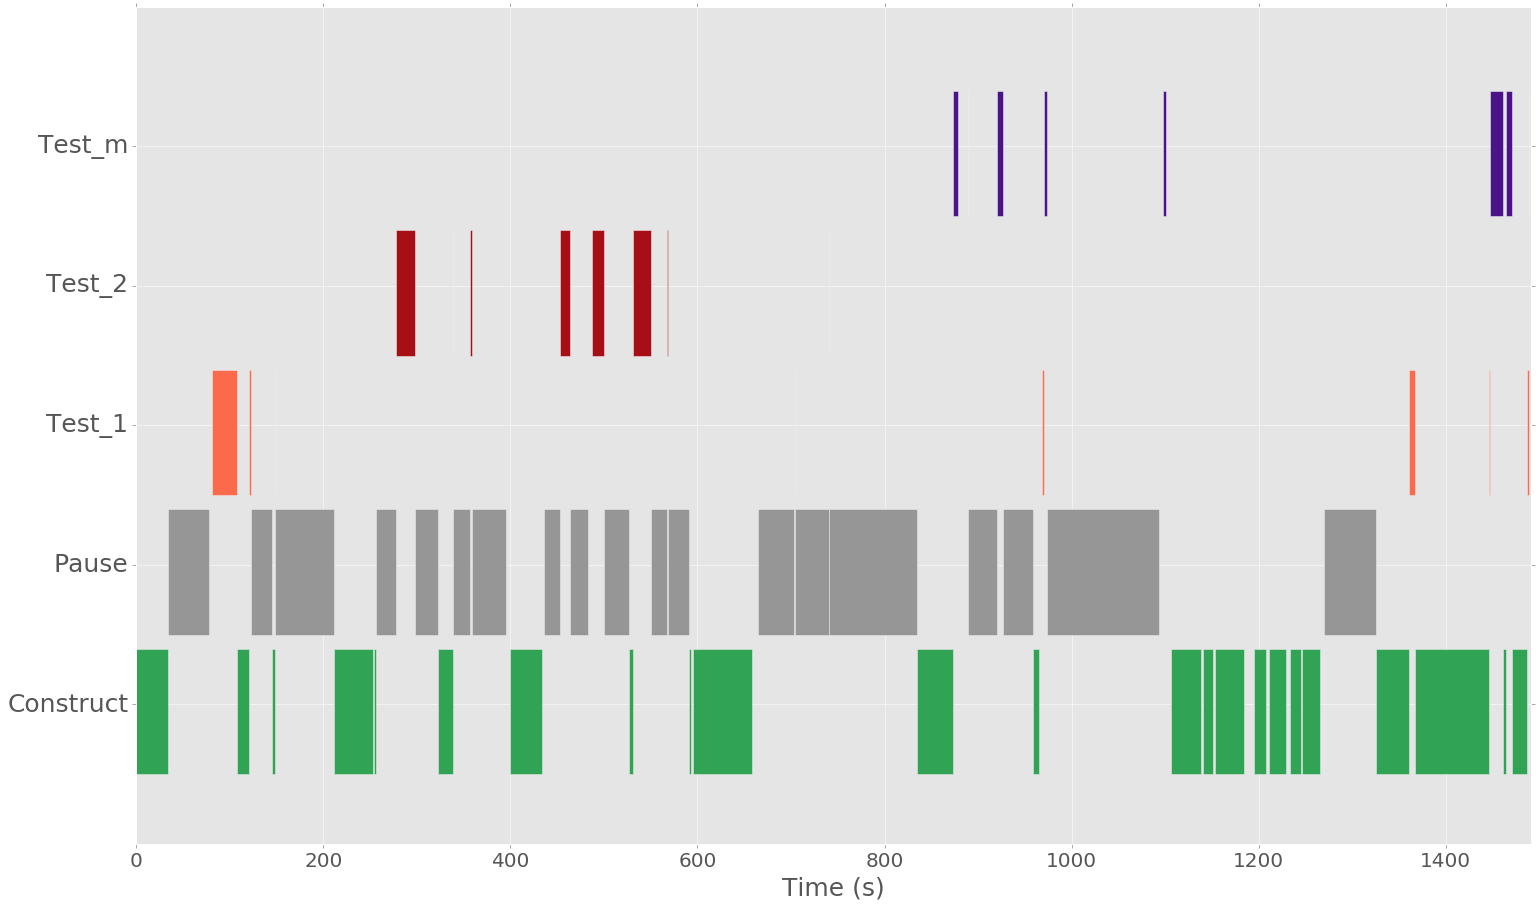

In [47]:
plot_barGraph_new(dfx,'a2',41045127, pltFamilies, axis_labels) #high high z-scores

In [48]:
# pick a student from above group
student = 91203122
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> 1.99


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
91,March,scaff,2,2,1,1,1,1,1,2,1,0.75,1.09,0.95,1.0,1.65,1.64,1.09,1.99,2.11,2.78,2.89,3.5,3.0,knowledge,scaffolded_knowledge,91203122,-345646792


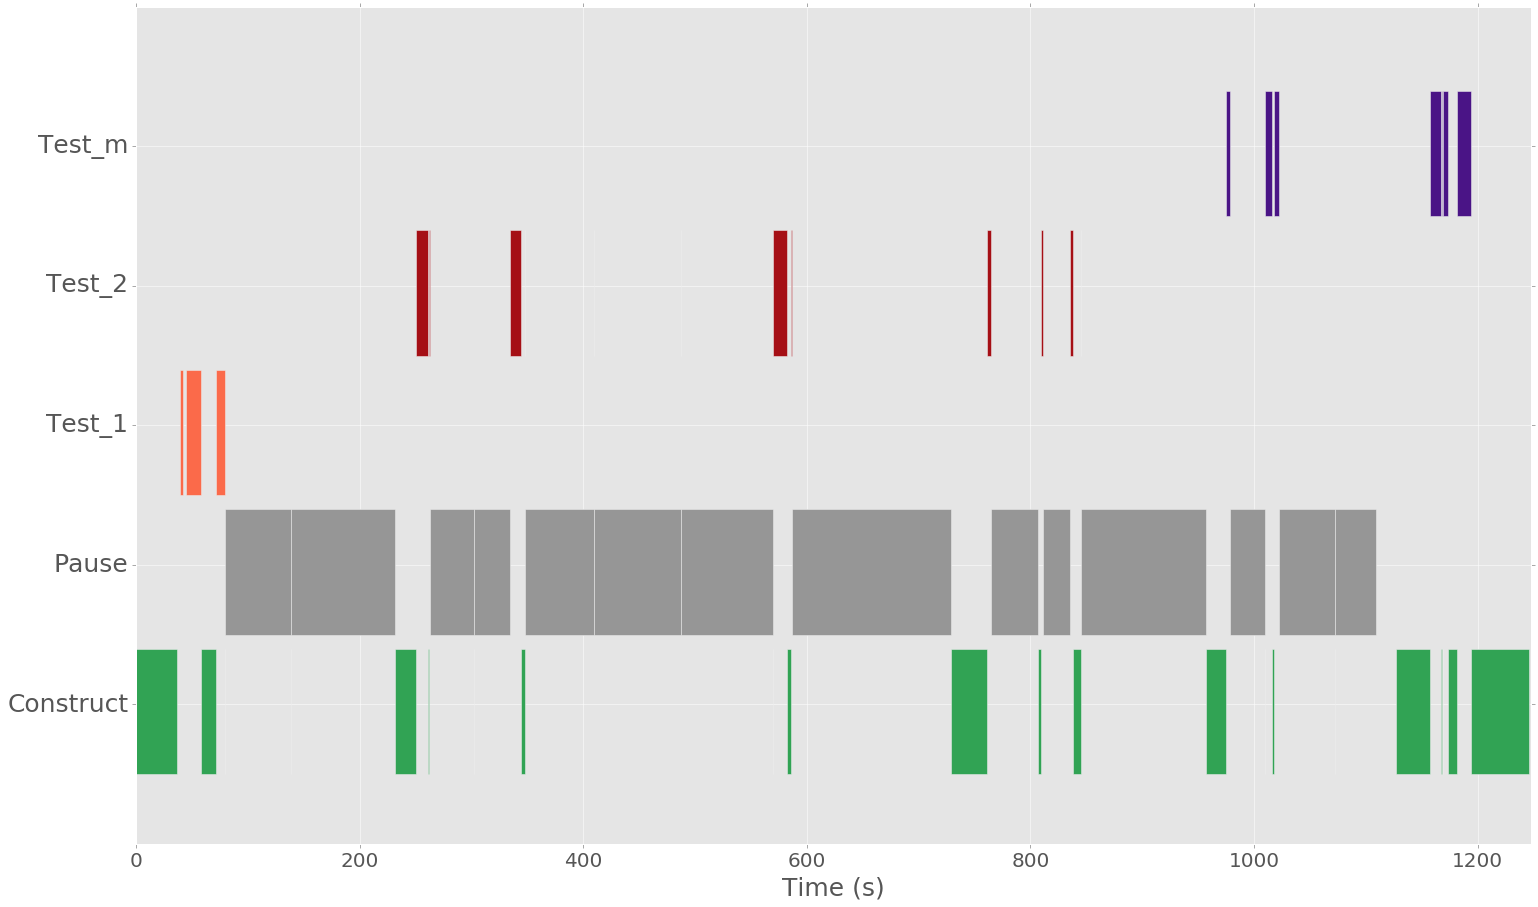

In [49]:
plot_barGraph_new(dfx,'a2',91203122, pltFamilies, axis_labels) #high high z-scores

In [50]:
# pick a student from above group
student = 13679110
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.92 --> 1.99


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
15,July,not,0,1,0,0,1,0,0,2,1,0.63,0.53,0.95,1.0,1.65,0.92,0.53,1.99,2.56,3.33,3.44,5.0,2.5,knowledge,notscaffolded_knowledge,13679110,-851238000


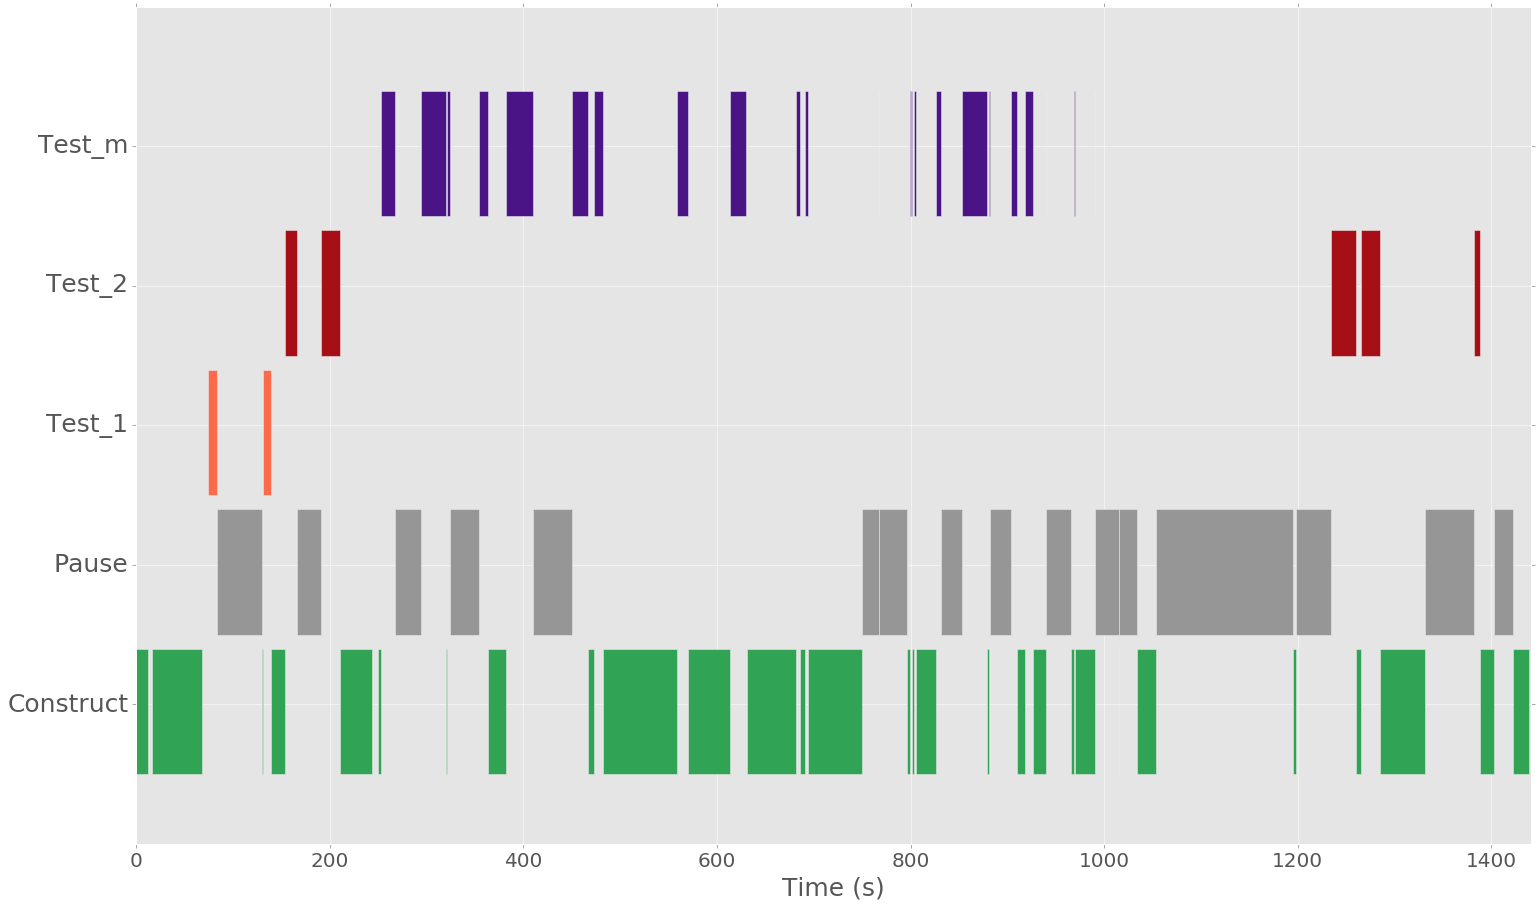

In [51]:
plot_barGraph_new(dfx,'a2',13679110, pltFamilies, axis_labels) #high high z-scores

### High low students

In [52]:
df_scores.loc[df_scores['student'].isin(HL_students)][['student','z pre','z post t2']]

,student,z pre,z post t2
32,31091114,1.64,-1.07
75,82224125,1.40,-0.36
93,94186123,1.64,-0.52


In [53]:
# pick a student from above group
student = 31091114
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> -1.07


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
32,July,not,3,2,1,1,0,1,1,1,1,0.75,0.73,0.38,0.5,-0.52,1.64,0.73,-1.07,2.44,1.89,2.78,4.0,2.25,knowledge,notscaffolded_knowledge,31091114,-1447878640


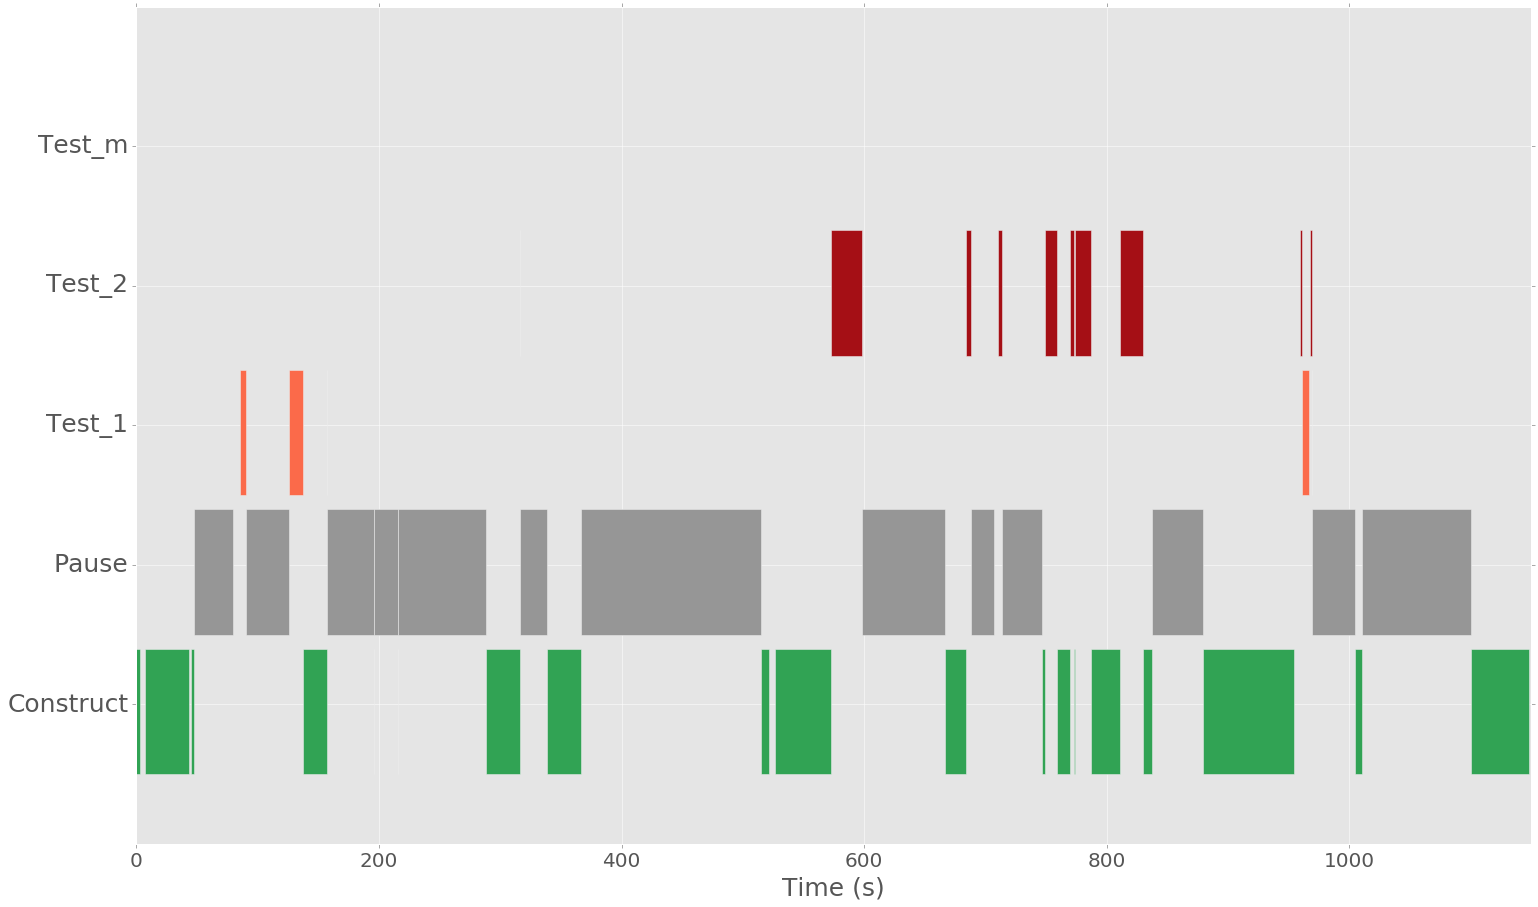

In [54]:
plot_barGraph_new(dfx,'a2',31091114, pltFamilies, axis_labels) #high low z-scores

In [55]:
# pick a student from above group
student = 82224125
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.4 --> -0.36


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
75,March,not,2,3,0,1,0,1,1,1,1,0.71,0.33,0.51,0.67,0.2,1.4,0.33,-0.36,2.67,2.78,2.89,2.0,3.0,knowledge,notscaffolded_knowledge,82224125,960603148


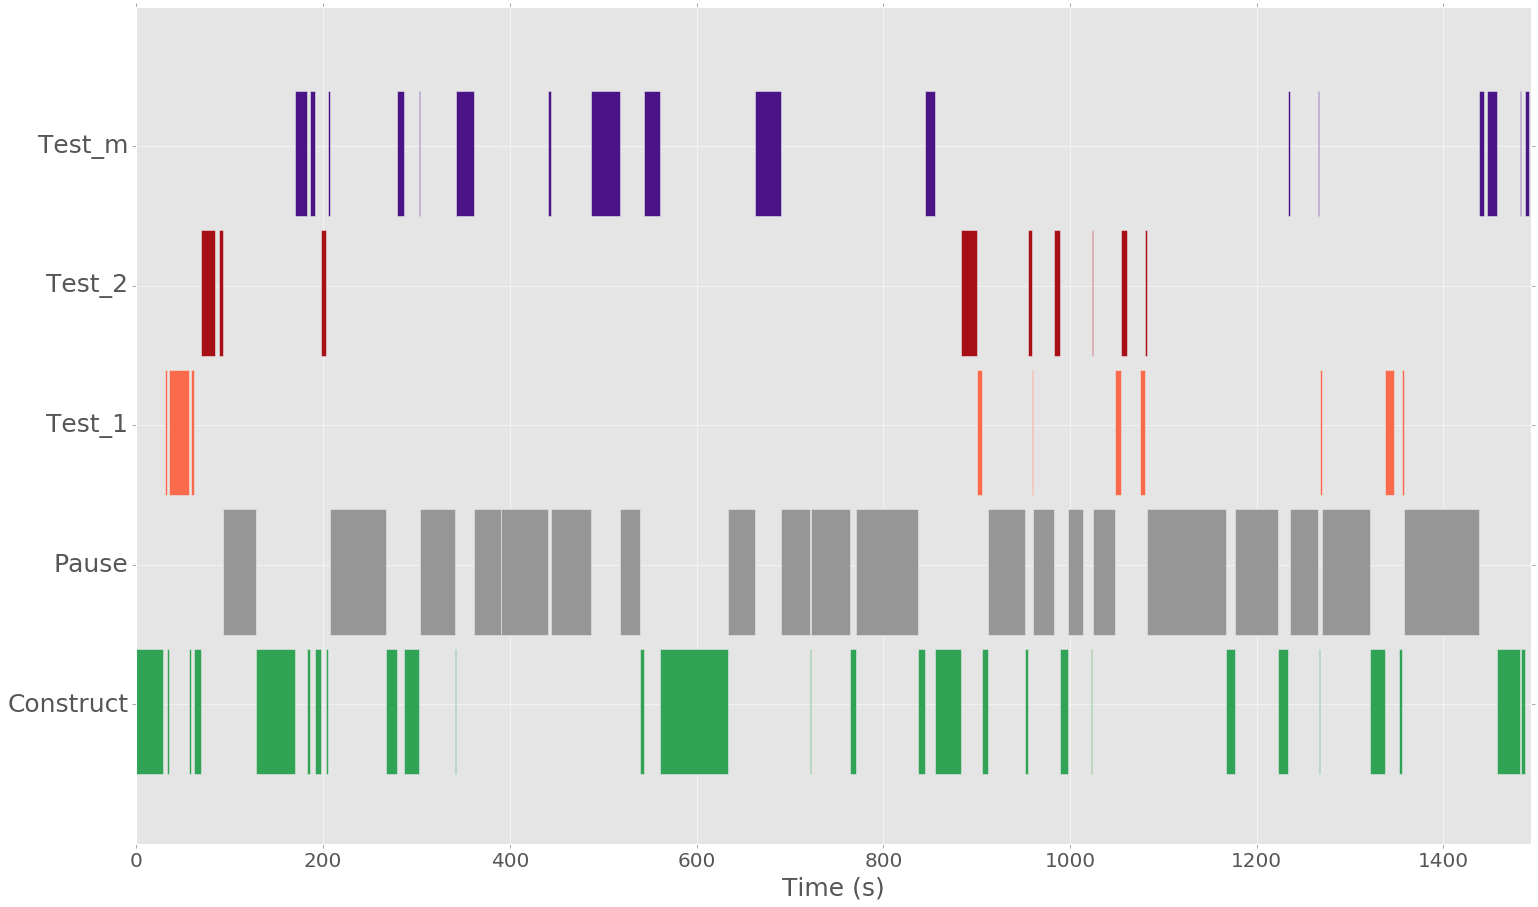

In [56]:
plot_barGraph_new(dfx,'a2',82224125, pltFamilies, axis_labels) #high low z-scores

In [57]:
# pick a student from above group
student = 94186123
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
1.64 --> -0.52


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
93,March,not,3,2,1,1,0,0,0,1,1,0.75,-1.68,0.48,0.58,-0.16,1.64,-1.68,-0.52,2.33,2.0,2.33,3.5,3.0,knowledge,notscaffolded_knowledge,94186123,399993022


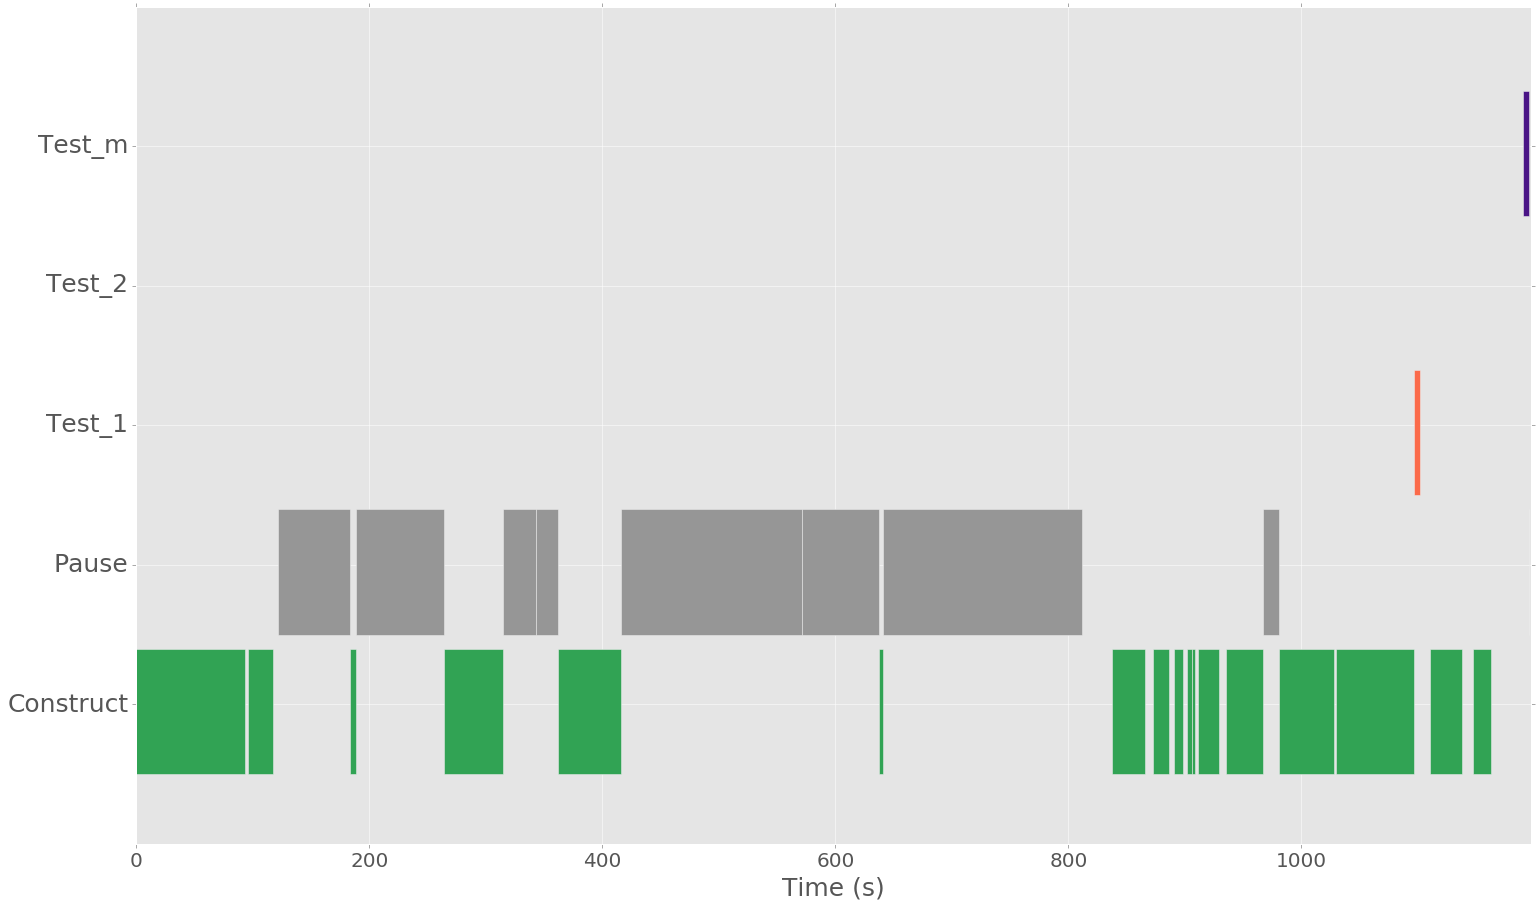

In [58]:
plot_barGraph_new(dfx,'a2',94186123, pltFamilies, axis_labels) #high low z-scores

### LH students that did not do top ranked sequences

In [59]:
student = 60076128
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> -0.12


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
53,March,not,3,4,1,1,1,1,1,1,0,0.38,0.08,0.55,0.63,0.02,-0.54,0.08,-0.12,3.56,3.11,2.89,4.0,3.0,attitude,notscaffolded_attitude,60076128,-186454172


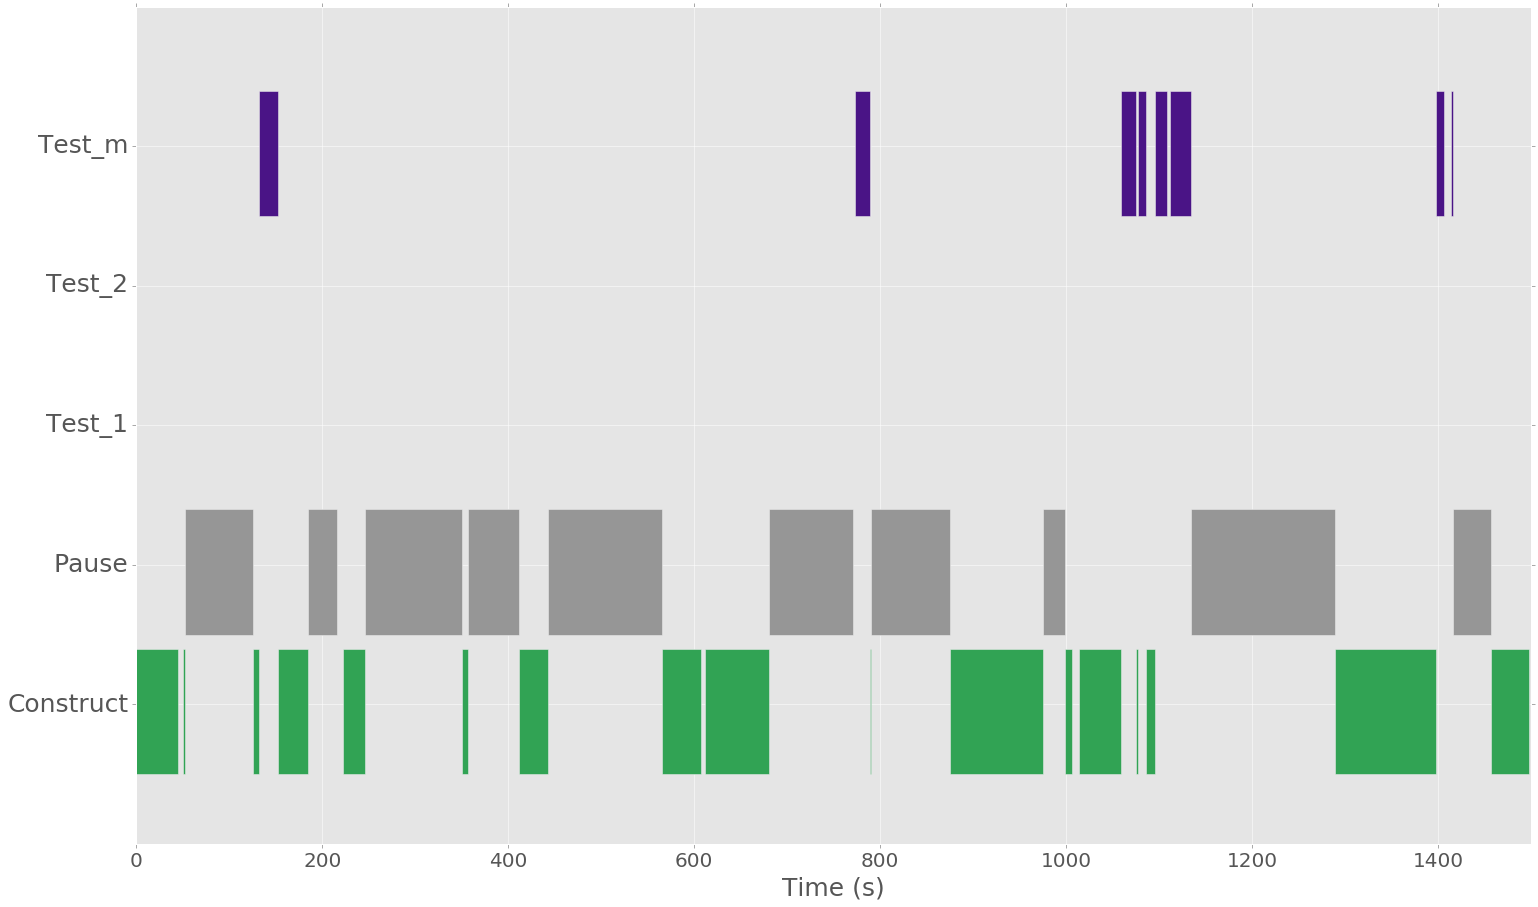

In [60]:
plot_barGraph_new(dfx,'a2',60076128, pltFamilies, axis_labels) 

In [61]:
student = 64944126
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.06 --> 1.59


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
61,March,not,3,4,1,1,1,1,1,1,1,0.46,1.09,0.88,0.75,0.57,-0.06,1.09,1.59,3.22,3.44,3.22,4.0,3.25,attitude,notscaffolded_attitude,64944126,1875089320


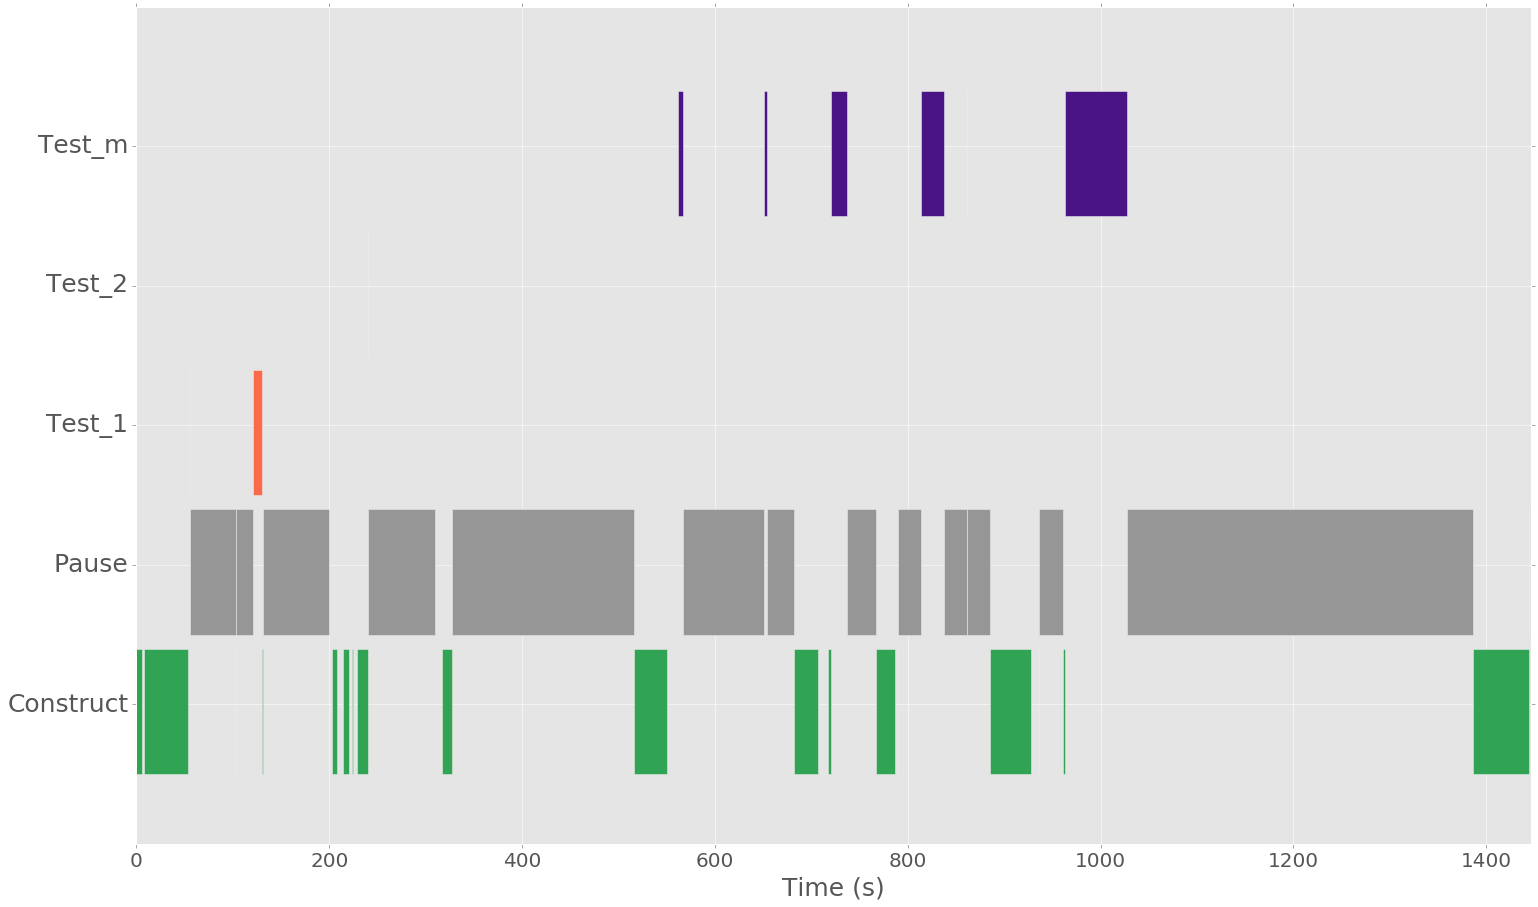

In [62]:
plot_barGraph_new(dfx,'a2',64944126, pltFamilies, axis_labels) #high low z-scores

In [63]:
student = 13378139
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.06 --> 1.03


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
14,July,scaff,3,3,0,0,1,1,1,0,1,0.46,0.73,0.77,0.79,0.75,-0.06,0.73,1.03,2.89,3.0,2.89,3.5,3.5,attitude,scaffolded_attitude,13378139,2094049475


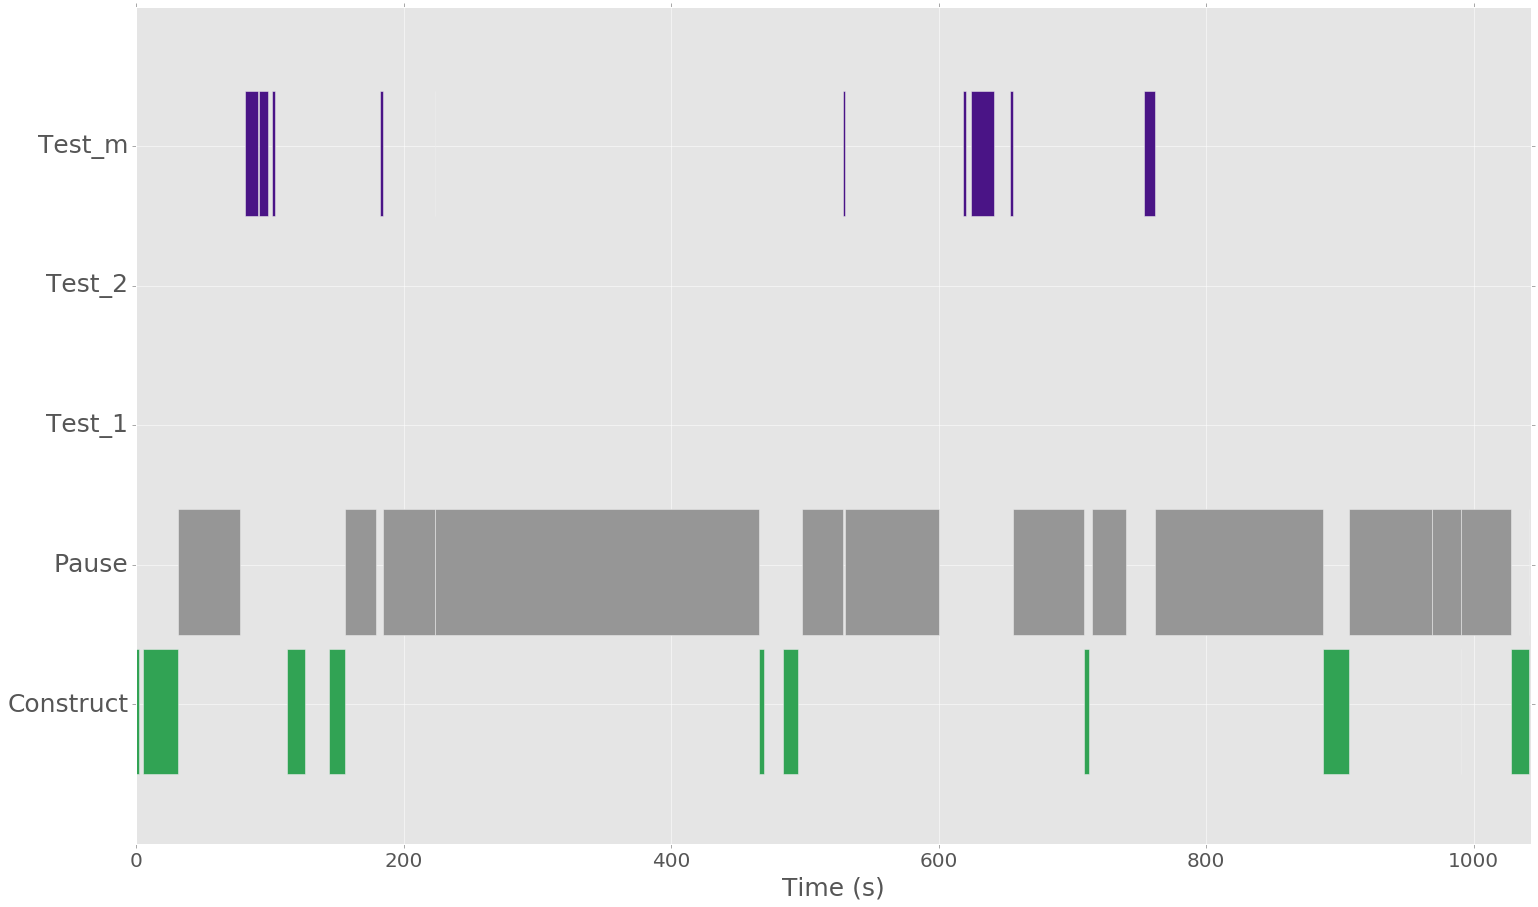

In [64]:
plot_barGraph_new(dfx,'a2',13378139, pltFamilies, axis_labels) #high low z-scores

In [65]:
student = 88156121
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -0.18


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
87,March,not,1,2,0,0,1,0,1,0,1,0.5,-1.93,0.54,0.75,0.57,0.19,-1.93,-0.18,2.22,2.44,2.22,4.0,3.0,knowledge,notscaffolded_knowledge,88156121,-1223736634


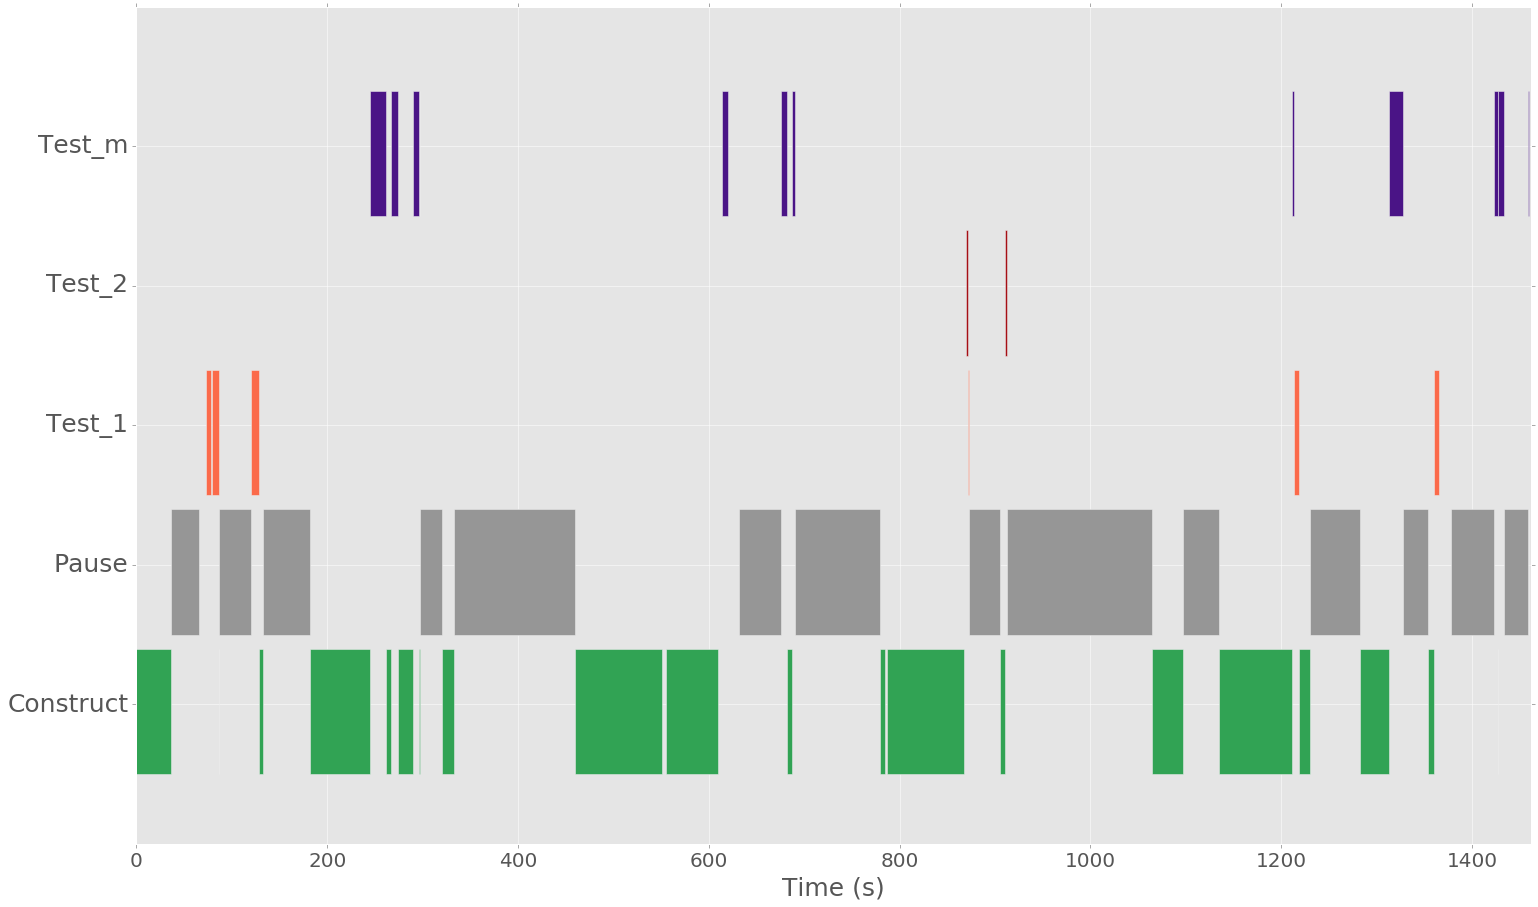

In [66]:
plot_barGraph_new(dfx,'a2',88156121, pltFamilies, axis_labels) #high low z-scores

In [67]:
student = 39619124
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> 0.48


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
38,March,scaff,3,3,1,0,1,1,1,2,1,0.38,0.58,0.67,0.83,0.93,-0.54,0.58,0.48,3.33,3.89,3.67,4.0,3.25,attitude,scaffolded_attitude,39619124,1872053375


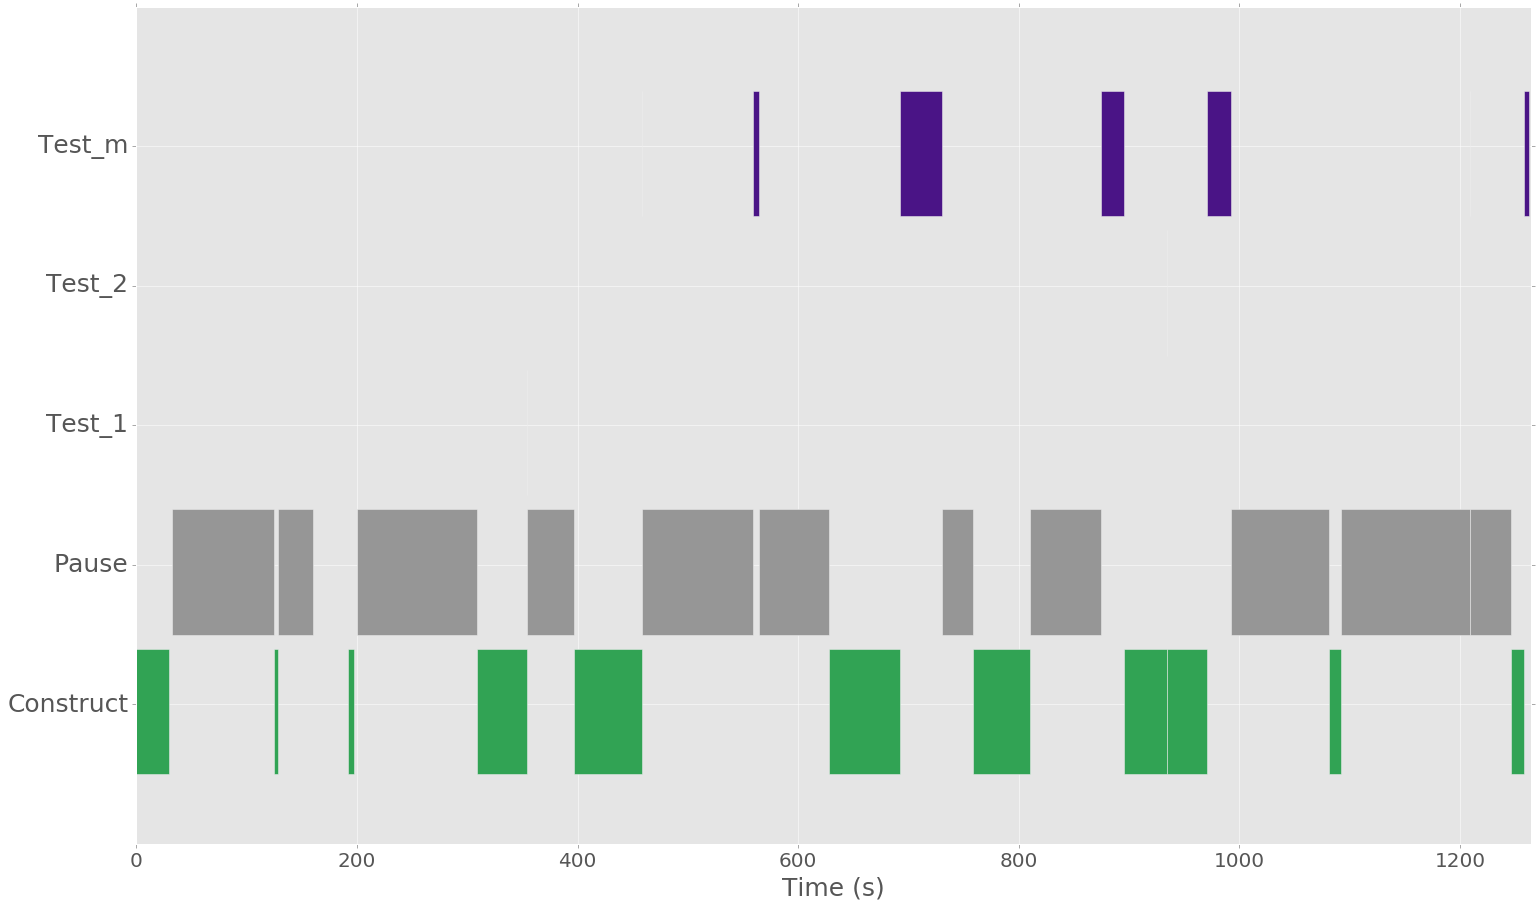

In [68]:
plot_barGraph_new(dfx,'a2',39619124, pltFamilies, axis_labels) #high low z-scores

### LL students that did not do top ranked sequences

In [69]:
student = 70209120
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -1.49


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
69,March,scaff,2,4,0,0,0,0,1,0,0,0.5,-0.42,0.3,0.13,-2.15,0.19,-0.42,-1.49,3.67,3.67,4.0,4.0,4.0,attitude,scaffolded_attitude,70209120,238592975


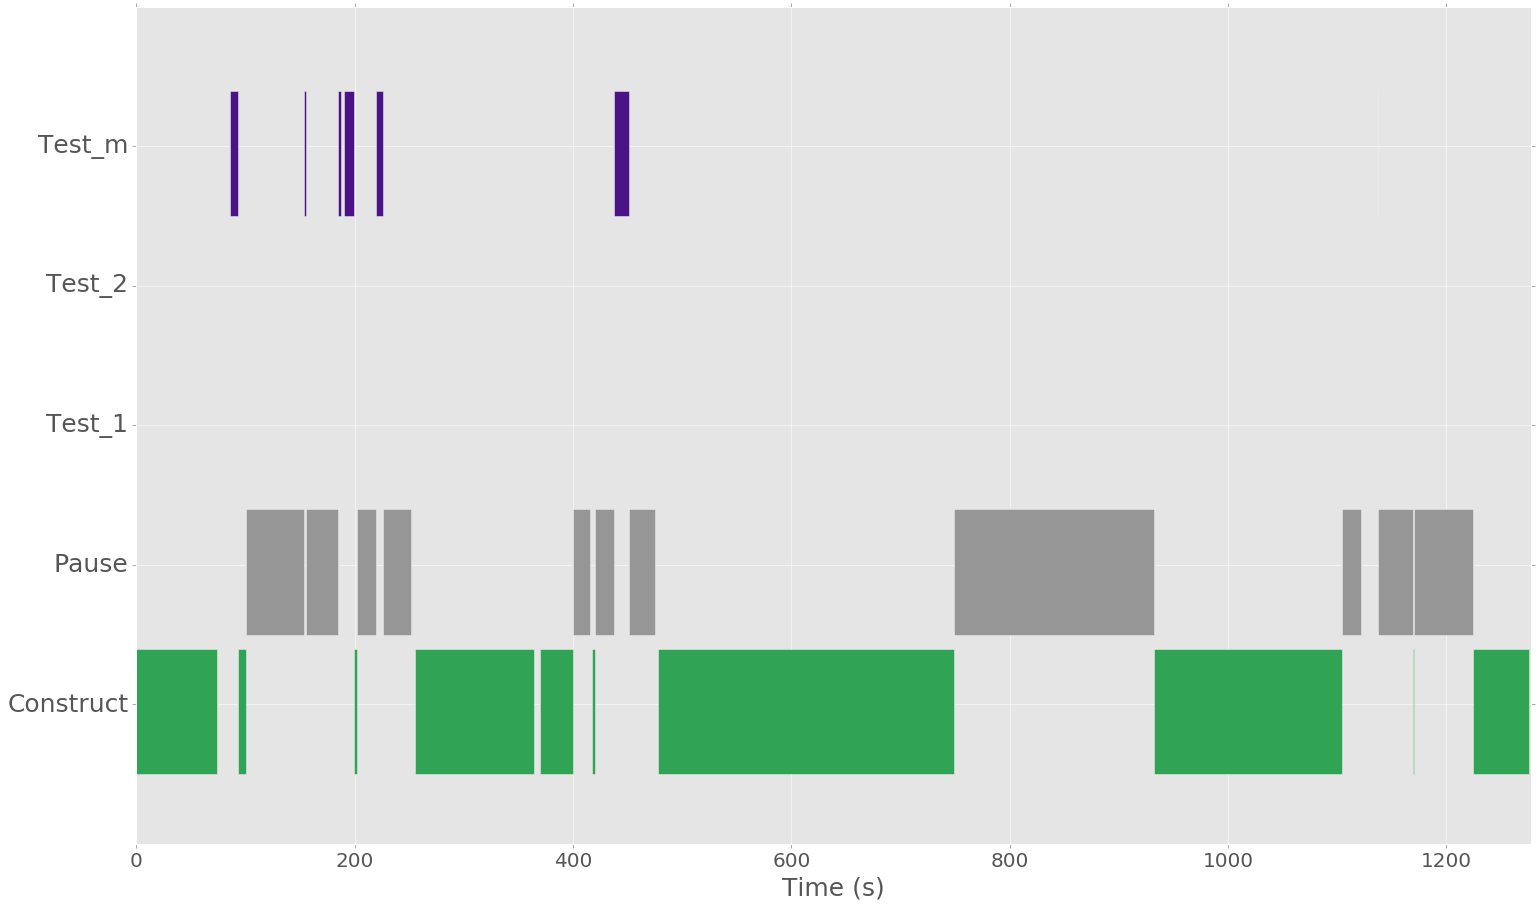

In [70]:
plot_barGraph_new(dfx,'a2',70209120, pltFamilies, axis_labels) #high low z-scores

In [71]:
student = 41295172
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> -0.49


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
40,March,scaff,0,1,0,0,0,0,1,0,0,0.38,1.09,0.48,0.42,-0.88,-0.54,1.09,-0.49,2.67,2.78,2.56,3.5,3.0,attitude,scaffolded_attitude,41295172,-946428309


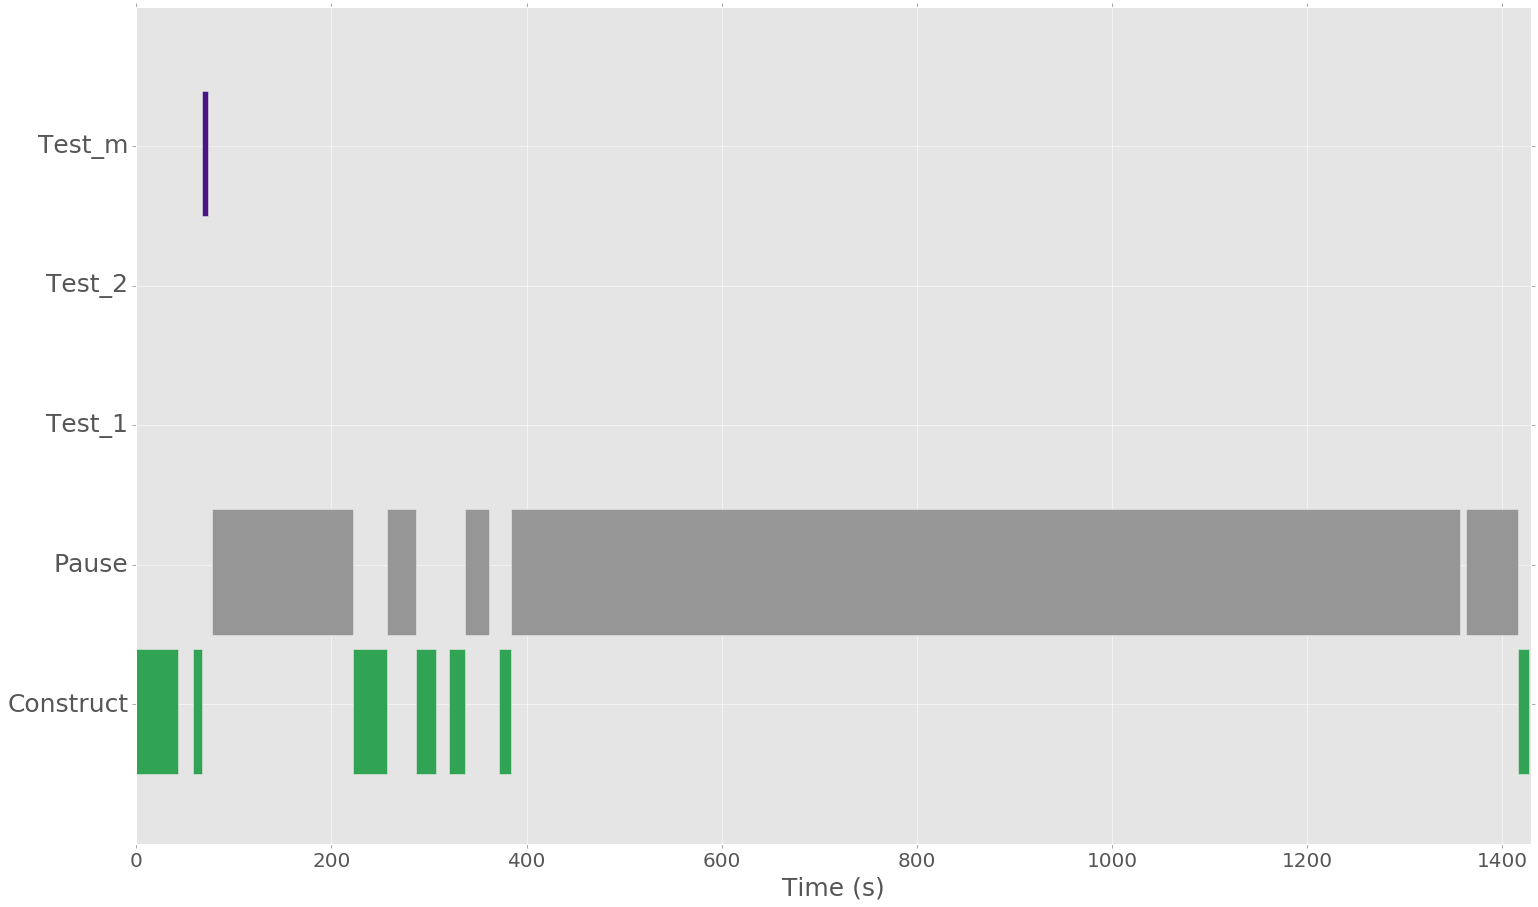

In [72]:
plot_barGraph_new(dfx,'a2',41295172, pltFamilies, axis_labels) #high low z-scores

In [73]:
student = 17070059
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
0.19 --> -0.78


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
18,July,scaff,0,1,0,0,1,0,1,0,1,0.5,-1.34,0.43,0.46,-0.7,0.19,-1.34,-0.78,2.0,1.89,2.33,4.0,3.0,knowledge,scaffolded_knowledge,17070059,-1018997059


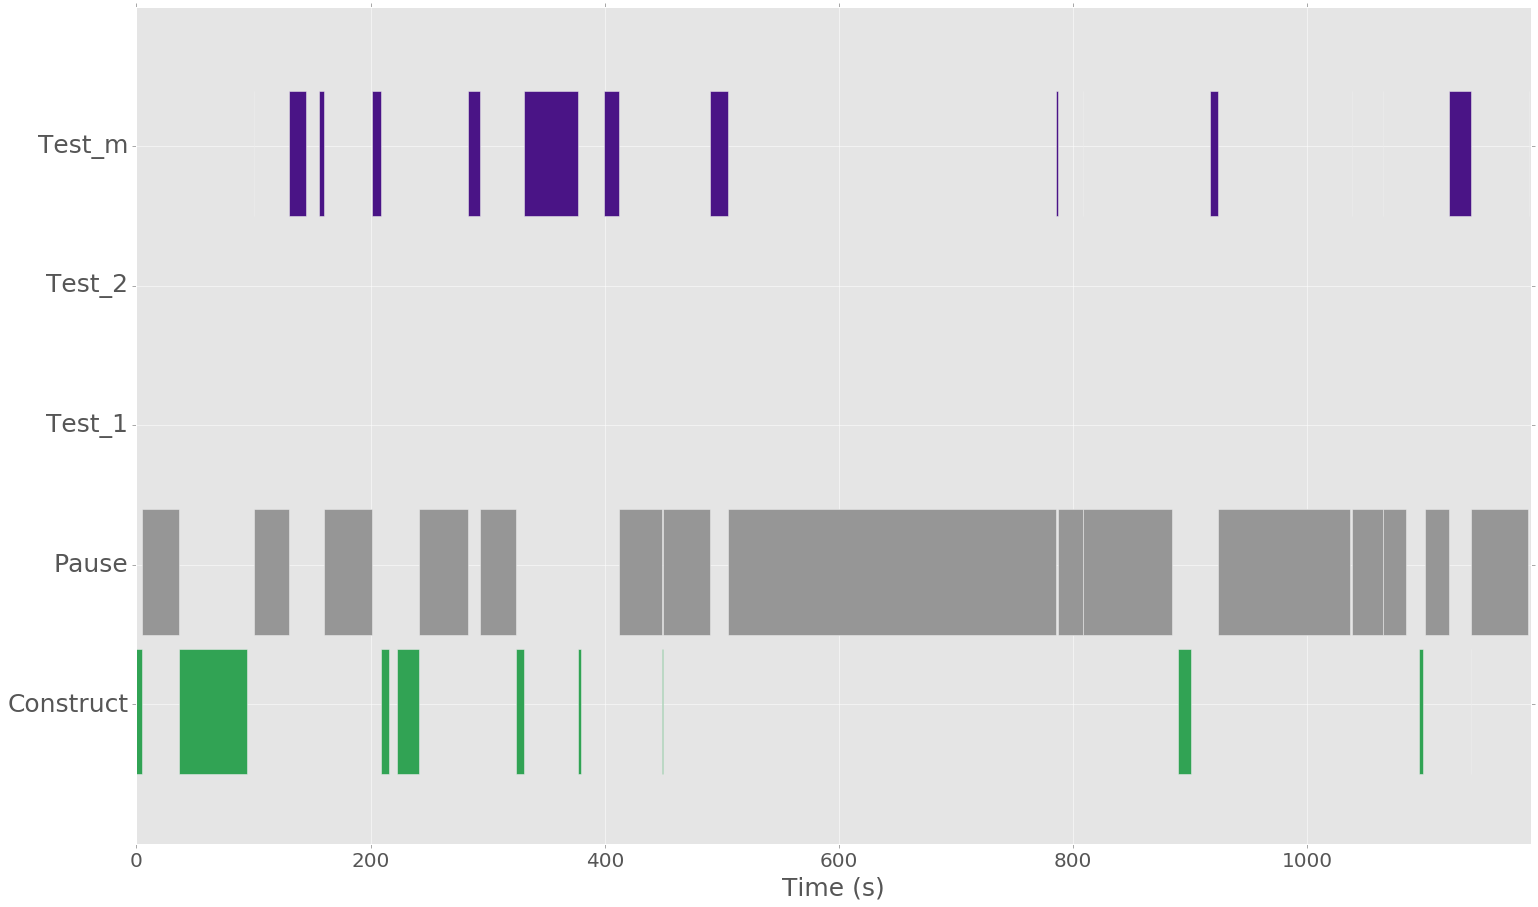

In [74]:
plot_barGraph_new(dfx,'a2',17070059, pltFamilies, axis_labels) #high low z-scores

In [75]:
student = 9331415
# print and display all test and survey info on this student:
print 'pre', '-->', 'post'
print float(df_scores[df_scores["student"]==student]['z pre']), '-->', float(df_scores[df_scores["student"]==student]['z post t2'])
df_scores[df_scores["student"]==student] 

pre --> post
-0.54 --> -1.49


,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
8,July,scaff,1,2,1,0,1,0,1,2,1,0.38,-1.34,0.3,0.29,-1.43,-0.54,-1.34,-1.49,2.33,2.78,3.0,2.5,2.25,knowledge,scaffolded_knowledge,9331415,-1573761483


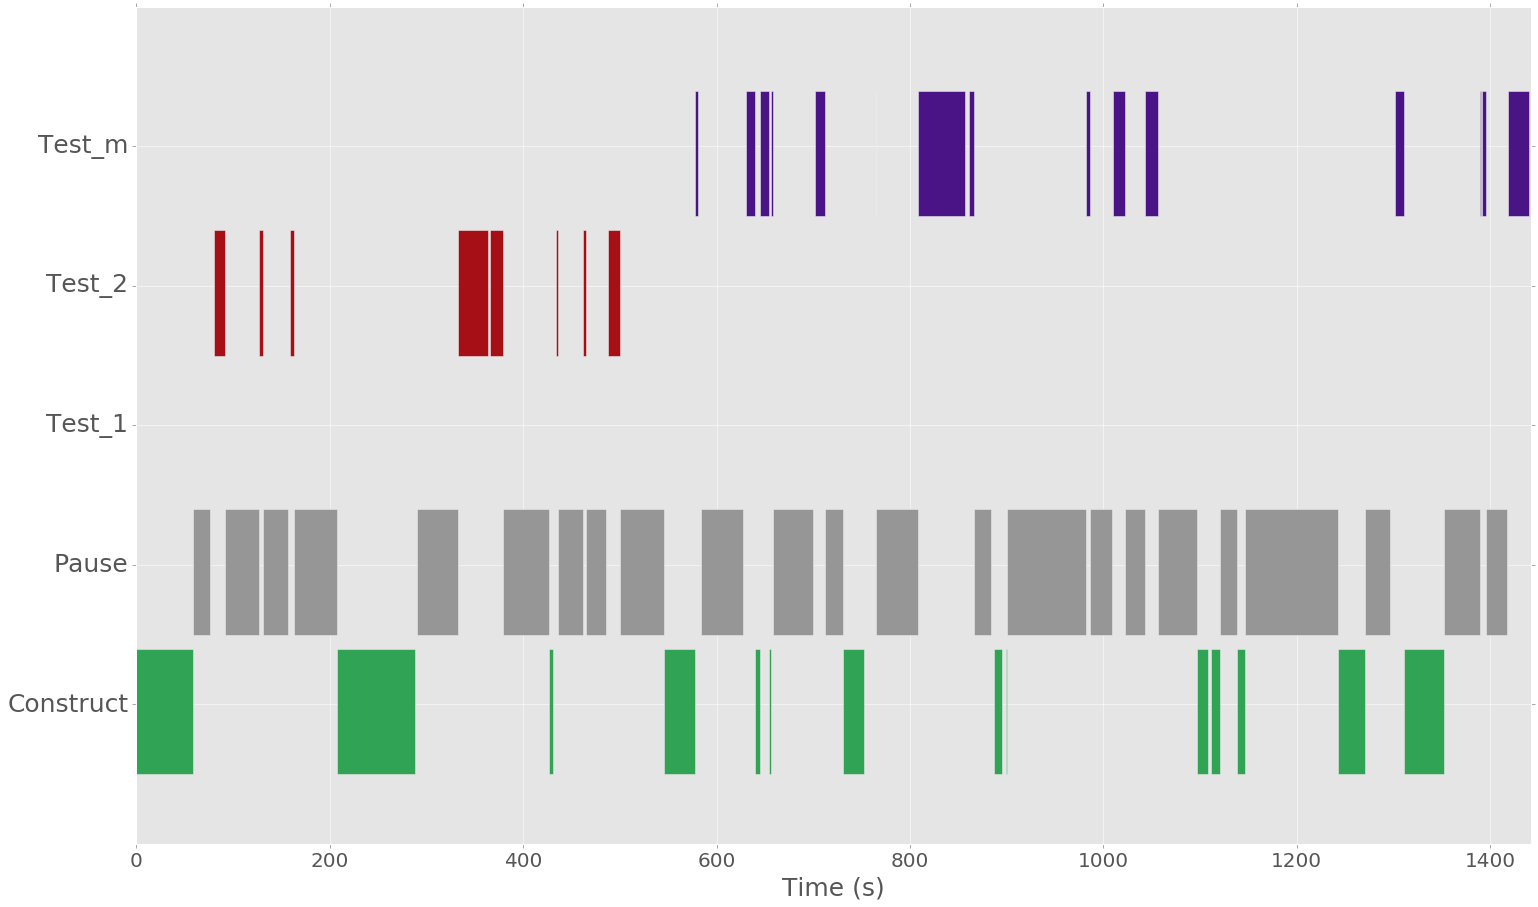

In [76]:
plot_barGraph_new(dfx,'a2',9331415, pltFamilies, axis_labels) #high low z-scores